<a href="https://colab.research.google.com/github/yeon524/TEAM_PROJECT/blob/main/%EB%AC%BC%EB%A5%98_%EC%84%BC%ED%84%B0%EC%A0%9C%EC%95%BD_CPLEX%2BALNS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 12.3 MB/s eta 0:00:00

[A_NoConstraint_ALNS] MILP + ALNS VRP 풀이 시작
  λ = None, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Optimal
개설된 DC: [1, 2, 3]
  DC 1 | ALNS VRP 거리 = 138.33, routes 개수 = 1
  DC 2 | ALNS VRP 거리 = 288.53, routes 개수 = 3
  DC 3 | ALNS VRP 거리 = 143.58, routes 개수 = 2

[A_NoConstraint_ALNS] 결과 요약
  개설된 DC: [1, 2, 3]
  개설비용: 120
  VRP 비용: 570.4380422656918
  총비용: 690.4380422656918


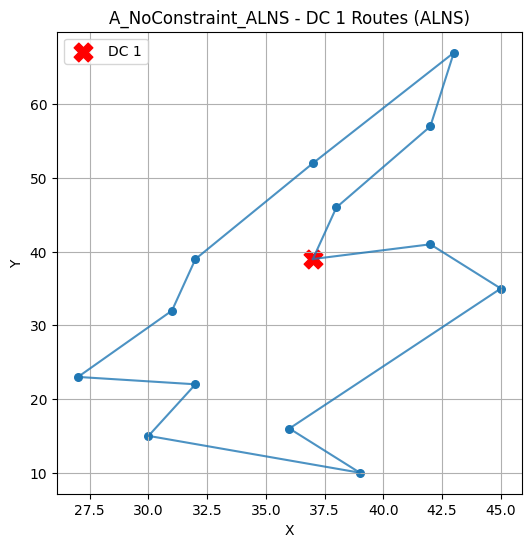

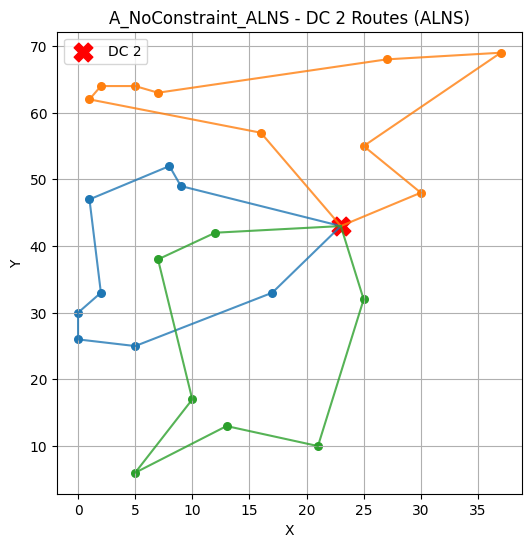

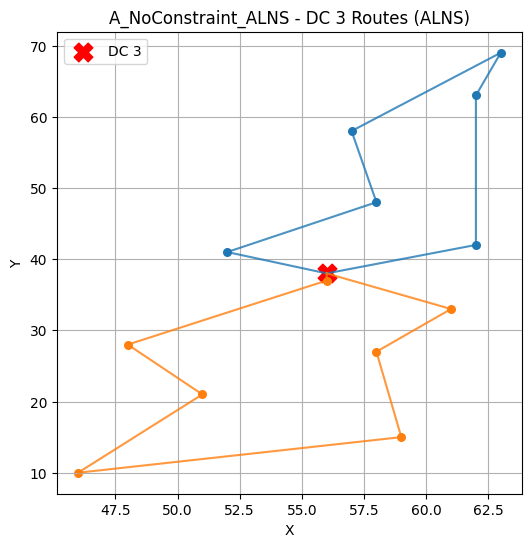


=== B_LambdaOnly — λ grid search (ALNS) ===

[B_LambdaOnly_lam0.1_ALNS] MILP + ALNS VRP 풀이 시작
  λ = 0.1, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Infeasible
 → 최적해를 찾지 못했거나 infeasible 입니다.
  λ=0.10 → infeasible

[B_LambdaOnly_lam0.15_ALNS] MILP + ALNS VRP 풀이 시작
  λ = 0.15, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Infeasible
 → 최적해를 찾지 못했거나 infeasible 입니다.
  λ=0.15 → infeasible

[B_LambdaOnly_lam0.2_ALNS] MILP + ALNS VRP 풀이 시작
  λ = 0.2, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Infeasible
 → 최적해를 찾지 못했거나 infeasible 입니다.
  λ=0.20 → infeasible

[B_LambdaOnly_lam0.25_ALNS] MILP + ALNS VRP 풀이 시작
  λ = 0.25, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Optimal
개설된 DC: [0, 1, 2, 3, 4]
  DC 0 | ALNS VRP 거리 = 127.49, routes 개수 = 2
  DC 1 | ALNS VRP 거리 = 156.06, routes 개수 = 2
  DC 2 | ALNS VRP 거리 = 170.35, routes 개수 = 2
  DC 3 | ALNS VRP 거리 = 127.57, routes 개수 = 2
  DC 4 | ALNS VRP 거리 = 67.29, routes 개수 = 1

[B_LambdaOnly_lam0.25_ALNS] 결과 요약
  개설된 DC:

In [1]:
# =========================================================
# Colab 버전 코드 (CPLEX + ALNS)
# - MILP: PuLP + CPLEX_PY  → DC 개설/배정 (Facility Location)
# - VRP: ALNS 기반 CVRP (트럭 용량 160, depot 복귀)
# - 케이스 A/B/C/D 4개 한 번에 실행
#   * B: λ 자동 탐색
#   * C: min_cust 자동 탐색
#   * D: (λ, min_cust) 그리드 서치
# =========================================================

!pip install pulp cplex --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import pulp

# ---------------------------------------------
# 0) 데이터 로드
# ---------------------------------------------
customer = pd.read_csv("/content/Customer.csv").reset_index().rename(columns={"index": "Customer_ID"})
dc       = pd.read_csv("/content/DistributionCenter.csv").reset_index().rename(columns={"index": "DC_ID"})
truck    = pd.read_csv("/content/Truck.csv")

C = len(customer)   # 고객 수 (예: 50)
D = len(dc)         # DC 수   (예: 5)

TRUCK_CAPACITY = int(truck["CAPACITY"].iloc[0])   # 예: 160
open_cost_j    = dc["COST"].values               # DC 개설비용
dc_capacity_j  = dc["CAPACITY"].values           # DC 보관용량

demand        = customer["DEMAND"].values
total_demand  = demand.sum()

cust_coords = [(customer.loc[i, "X"], customer.loc[i, "Y"]) for i in range(C)]
dc_coords   = [(dc.loc[j, "X"],       dc.loc[j, "Y"])       for j in range(D)]

# ---------------------------------------------
# 1) 유틸 (거리)
# ---------------------------------------------
def euclid(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

# ---------------------------------------------
# 2) ALNS용 CVRP 유틸 함수들
#    - route 표현: [0, i1, i2, ..., 0]
#    - demands[0] = 0, 나머지는 고객 수요
# ---------------------------------------------
def compute_route_cost(route, dist_matrix):
    """ route: [0, i1, i2, ..., 0] """
    c = 0.0
    for k in range(len(route) - 1):
        c += dist_matrix[route[k]][route[k+1]]
    return c

def compute_total_cost(routes, dist_matrix):
    return sum(compute_route_cost(r, dist_matrix) for r in routes)

def compute_route_demand(route, demands):
    """ route 안 고객 수요 합 (depot=0은 제외) """
    return sum(demands[node] for node in route if node != 0)

def initial_solution_greedy(demands, dist_matrix, vehicle_capacity, seed=0):
    """
    단순 greedy CVRP 초기해:
    - 고객 순서를 랜덤으로 섞고,
    - 남아 있는 용량이 되는 라우트에 차례대로 넣음
    - 안 들어가면 새 route 생성
    """
    random.seed(seed)
    np.random.seed(seed)

    n = len(demands)  # 0 포함
    customer_ids = list(range(1, n))
    random.shuffle(customer_ids)

    total_demand = sum(demands[1:])
    num_vehicles = max(1, int(np.ceil(total_demand / vehicle_capacity)))

    routes = []
    remaining_cap = []

    for _ in range(num_vehicles):
        routes.append([0, 0])  # depot → depot
        remaining_cap.append(vehicle_capacity)

    for cust in customer_ids:
        d = demands[cust]
        inserted = False
        for r_idx in range(len(routes)):
            if remaining_cap[r_idx] >= d:
                routes[r_idx].insert(-1, cust)
                remaining_cap[r_idx] -= d
                inserted = True
                break
        if not inserted:
            # 새 차량 추가
            routes.append([0, cust, 0])
            remaining_cap.append(vehicle_capacity - d)

    clean_routes = []
    for r in routes:
        if len(r) > 2:
            clean_routes.append(r)
    if not clean_routes:
        clean_routes = [[0, 0]]

    return clean_routes

# ---------------------------------------------
# 3) ALNS: Destroy 연산자들
# ---------------------------------------------
def destroy_random(routes, num_remove, demands=None, dist_matrix=None):
    """
    무작위 고객 제거
    """
    new_routes = copy.deepcopy(routes)
    removed = []

    # 모든 고객 리스트
    all_customers = []
    for r in new_routes:
        for node in r:
            if node != 0:
                all_customers.append(node)

    random.shuffle(all_customers)
    to_remove = all_customers[:num_remove]

    for cust in to_remove:
        for r in new_routes:
            if cust in r:
                r.remove(cust)
                removed.append(cust)
                break

    # 빈 라우트 제거
    cleaned_routes = []
    for r in new_routes:
        if len(r) > 2:
            cleaned_routes.append(r)
    if not cleaned_routes:
        cleaned_routes = [[0, 0]]

    return cleaned_routes, removed

def destroy_worst(routes, num_remove, demands, dist_matrix):
    """
    '비용에 많이 기여하는' 고객 위주 제거:
    각 고객의 marginal cost (해당 customer 앞/뒤 기준)를 대략 계산해서 큰 순서대로 제거
    """
    new_routes = copy.deepcopy(routes)
    customer_marginal = []

    for r_idx, r in enumerate(new_routes):
        if len(r) <= 2:
            continue
        for p in range(1, len(r)-1):
            c = r[p]
            prev_node = r[p-1]
            next_node = r[p+1]
            # customer c를 제거했을 때 감소하는 비용 근사
            delta = dist_matrix[prev_node][c] + dist_matrix[c][next_node] - dist_matrix[prev_node][next_node]
            customer_marginal.append((c, r_idx, p, delta))

    if not customer_marginal:
        return destroy_random(routes, num_remove, demands, dist_matrix)

    customer_marginal.sort(key=lambda x: x[3], reverse=True)  # delta 큰 순

    removed = []
    used = set()
    for info in customer_marginal:
        c, r_idx, p, delta = info
        if c in used:
            continue
        used.add(c)
        removed.append(c)
        if len(removed) >= num_remove:
            break

    for c in removed:
        for r in new_routes:
            if c in r:
                r.remove(c)
                break

    cleaned_routes = []
    for r in new_routes:
        if len(r) > 2:
            cleaned_routes.append(r)
    if not cleaned_routes:
        cleaned_routes = [[0, 0]]

    return cleaned_routes, removed

def destroy_route(routes, num_remove, demands=None, dist_matrix=None):
    """
    통째로 라우트 하나(또는 일부)를 날리는 destroy:
    - 랜덤 라우트 하나 고른 뒤, 그 안에서 고객들 제거
    """
    new_routes = copy.deepcopy(routes)
    non_empty = [idx for idx, r in enumerate(new_routes) if len(r) > 2]
    if not non_empty:
        return destroy_random(routes, num_remove, demands, dist_matrix)

    r_idx = random.choice(non_empty)
    r = new_routes[r_idx]

    customers_in_route = [node for node in r if node != 0]
    random.shuffle(customers_in_route)

    removed = []
    for c in customers_in_route:
        if len(removed) >= num_remove:
            break
        r.remove(c)
        removed.append(c)

    cleaned_routes = []
    for rt in new_routes:
        if len(rt) > 2:
            cleaned_routes.append(rt)
    if not cleaned_routes:
        cleaned_routes = [[0, 0]]

    return cleaned_routes, removed

# Destroy 연산자 리스트
DESTROY_OPERATORS = [
    destroy_random,
    destroy_worst,
    destroy_route,
]

# ---------------------------------------------
# 4) ALNS: Repair 연산자들
# ---------------------------------------------
def insert_feasible_min_cost(routes, cust, demands, dist_matrix, vehicle_capacity):
    """
    한 고객 cust를 capacity 안에서 최소 증가 비용 위치에 삽입
    - 기존 route들 중 feasible한 곳에 넣고
    - feasible한 곳이 하나도 없으면 새 route 생성
    """
    best_cost = float("inf")
    best_r_idx = None
    best_pos = None

    for r_idx, r in enumerate(routes):
        # 각 가능한 위치에 삽입
        for pos in range(1, len(r)):  # depot 뒤 ~ 마지막 노드 앞까지
            new_route = r[:pos] + [cust] + r[pos:]
            if compute_route_demand(new_route, demands) > vehicle_capacity + 1e-9:
                continue
            delta = compute_route_cost(new_route, dist_matrix) - compute_route_cost(r, dist_matrix)
            if delta < best_cost:
                best_cost = delta
                best_r_idx = r_idx
                best_pos = pos

    if best_r_idx is not None:
        routes[best_r_idx] = routes[best_r_idx][:best_pos] + [cust] + routes[best_r_idx][best_pos:]
        return routes

    # 어디에도 못 넣으면 새 route 생성 (depot→cust→depot)
    routes.append([0, cust, 0])
    return routes

def repair_greedy(routes, removed, demands, dist_matrix, vehicle_capacity):
    """
    Greedy repair:
    - removed 고객들을 아무 순서대로 순차 삽입
    """
    new_routes = copy.deepcopy(routes)
    for cust in removed:
        new_routes = insert_feasible_min_cost(new_routes, cust, demands, dist_matrix, vehicle_capacity)
    return new_routes

def repair_regret2(routes, removed, demands, dist_matrix, vehicle_capacity):
    """
    Regret-2 기반 repair:
    - 각 고객에 대해 1, 2번째 best 삽입 비용 계산
    - (2번째 - 1번째) regret 값이 큰 고객부터 삽입
    """
    new_routes = copy.deepcopy(routes)
    remaining = set(removed)

    while remaining:
        best_c = None
        best_regret = -1
        best_position_info = None

        # 각 고객에 대해 best/second-best 삽입 위치 조사
        for cust in remaining:
            best1 = float("inf")
            best2 = float("inf")
            best1_info = None

            for r_idx, r in enumerate(new_routes):
                for pos in range(1, len(r)):
                    new_route = r[:pos] + [cust] + r[pos:]
                    if compute_route_demand(new_route, demands) > vehicle_capacity + 1e-9:
                        continue
                    delta = compute_route_cost(new_route, dist_matrix) - compute_route_cost(r, dist_matrix)
                    if delta < best1:
                        best2 = best1
                        best1 = delta
                        best1_info = (r_idx, pos)
                    elif delta < best2:
                        best2 = delta

            # 어떤 route에도 못 들어가면, 새 route 생성 고려 (regret은 0으로 처리)
            if best1_info is None:
                # 새 route 만들어서 넣는 delta는,
                # 그냥 0→cust→0 비용이라고 보고 사용
                delta_new_route = compute_route_cost([0, cust, 0], dist_matrix)
                best1 = delta_new_route
                best2 = delta_new_route
                best1_info = ("new", None)

            regret = best2 - best1
            if regret > best_regret:
                best_regret = regret
                best_c = cust
                best_position_info = (best1_info, best1)

        # best_c 삽입
        (r_info, pos), _ = best_position_info
        if r_info == "new":
            new_routes.append([0, best_c, 0])
        else:
            r_idx = r_info
            route = new_routes[r_idx]
            new_routes[r_idx] = route[:pos] + [best_c] + route[pos:]

        remaining.remove(best_c)

    return new_routes

# Repair 연산자 리스트
REPAIR_OPERATORS = [
    repair_greedy,
    repair_regret2,
]

# ---------------------------------------------
# 5) ALNS 메인 루프 (CVRP)
# ---------------------------------------------
def alns_cvrp(demands, dist_matrix, vehicle_capacity,
              max_iter=500,
              remove_fraction=0.2,
              reaction_factor=0.2,
              start_temp=1.0,
              end_temp=0.01,
              seed=0,
              verbose=False):
    """
    ALNS for CVRP (단일 depot)
    - representation: routes = [ [0, ..., 0], ... ]
    - demands[0] = 0
    """

    random.seed(seed)
    np.random.seed(seed)

    # 초기해
    current_routes = initial_solution_greedy(demands, dist_matrix, vehicle_capacity, seed=seed)
    current_cost   = compute_total_cost(current_routes, dist_matrix)

    best_routes = copy.deepcopy(current_routes)
    best_cost   = current_cost

    num_customers = len(demands) - 1
    num_remove = max(1, int(num_customers * remove_fraction))

    # destroy / repair operator별 weight / score 초기화
    nD = len(DESTROY_OPERATORS)
    nR = len(REPAIR_OPERATORS)

    destroy_weights = [1.0] * nD
    repair_weights  = [1.0] * nR

    destroy_scores = [0.0] * nD
    repair_scores  = [0.0] * nR

    def select_index(weights):
        s = sum(weights)
        r = random.random() * s
        acc = 0.0
        for i, w in enumerate(weights):
            acc += w
            if r <= acc:
                return i
        return len(weights) - 1

    def temperature(iteration):
        # 선형 cool-down
        return start_temp + (end_temp - start_temp) * (iteration / max_iter)

    if verbose:
        print(f"[ALNS] Initial cost = {best_cost:.2f}, routes = {best_routes}")

    for it in range(1, max_iter+1):
        T = temperature(it)

        # 1) 연산자 선택
        d_idx = select_index(destroy_weights)
        r_idx = select_index(repair_weights)

        destroy_op = DESTROY_OPERATORS[d_idx]
        repair_op  = REPAIR_OPERATORS[r_idx]

        # 2) Destroy + Repair 적용
        destroyed_routes, removed = destroy_op(current_routes, num_remove, demands, dist_matrix)
        candidate_routes = repair_op(destroyed_routes, removed, demands, dist_matrix, vehicle_capacity)
        candidate_cost   = compute_total_cost(candidate_routes, dist_matrix)

        # 3) 수용 여부 (SA 스타일)
        delta = candidate_cost - current_cost
        accept = False
        improvement = False

        if delta < -1e-9:
            # 현재해보다 개선
            accept = True
            improvement = True
        else:
            # 나빠도 확률적으로 수용
            prob = np.exp(-delta / max(T, 1e-9))
            if random.random() < prob:
                accept = True

        if accept:
            current_routes = candidate_routes
            current_cost   = candidate_cost

            # best 갱신
            if current_cost < best_cost - 1e-9:
                best_cost = current_cost
                best_routes = copy.deepcopy(current_routes)
                # best 개선된 경우 보상 크게
                destroy_scores[d_idx] += 3.0
                repair_scores[r_idx]  += 3.0
            elif improvement:
                # 현재해 개선이지만 best는 아님
                destroy_scores[d_idx] += 1.5
                repair_scores[r_idx]  += 1.5
            else:
                # 나빠졌지만 수용된 경우
                destroy_scores[d_idx] += 0.5
                repair_scores[r_idx]  += 0.5

        # 4) 주기적으로 weight 업데이트
        if it % 20 == 0:
            for i in range(nD):
                destroy_weights[i] = (1 - reaction_factor) * destroy_weights[i] + reaction_factor * max(destroy_scores[i], 1e-6)
                destroy_scores[i] = 0.0
            for i in range(nR):
                repair_weights[i] = (1 - reaction_factor) * repair_weights[i] + reaction_factor * max(repair_scores[i], 1e-6)
                repair_scores[i] = 0.0

        if verbose and (it % 100 == 0 or it == max_iter):
            print(f"[Iter {it}] current={current_cost:.2f}, best={best_cost:.2f}, T={T:.4f}")

    return best_cost, best_routes

def solve_vrp_alns(demands, dist_matrix, vehicle_capacity,
                   max_iter=500,
                   remove_fraction=0.2,
                   seed=0,
                   verbose=False):
    cost, routes = alns_cvrp(
        demands=demands,
        dist_matrix=dist_matrix,
        vehicle_capacity=vehicle_capacity,
        max_iter=max_iter,
        remove_fraction=remove_fraction,
        reaction_factor=0.2,
        start_temp=1.0,
        end_temp=0.01,
        seed=seed,
        verbose=verbose
    )
    return cost, routes

# ---------------------------------------------
# 6) MILP 모델 생성 (CPLEX 그대로)
# ---------------------------------------------
def build_milp_model(lam=None, min_cust=None, use_capacity=True):
    model = pulp.LpProblem("FacilityLocation_Generic", pulp.LpMinimize)

    y = pulp.LpVariable.dicts("OpenDC", range(D), cat="Binary")
    x = pulp.LpVariable.dicts("Assign", (range(C), range(D)), cat="Binary")

    dist_cost = np.zeros((C, D))
    for i in range(C):
        for j in range(D):
            dist_cost[i, j] = euclid(cust_coords[i], dc_coords[j])

    model += (
        pulp.lpSum([y[j] * open_cost_j[j] for j in range(D)]) +
        pulp.lpSum([x[i][j] * dist_cost[i, j] for i in range(C) for j in range(D)])
    )

    for i in range(C):
        model += pulp.lpSum([x[i][j] for j in range(D)]) == 1

    for i in range(C):
        for j in range(D):
            model += x[i][j] <= y[j]

    if lam is not None:
        max_load = lam * total_demand
        for j in range(D):
            model += pulp.lpSum([x[i][j] * demand[i] for i in range(C)]) <= max_load

    if min_cust is not None:
        for j in range(D):
            model += pulp.lpSum([x[i][j] for i in range(C)]) >= min_cust * y[j]

    if use_capacity:
        for j in range(D):
            model += pulp.lpSum([x[i][j] * demand[i] for i in range(C)]) <= dc_capacity_j[j]

    return model, x, y

# ---------------------------------------------
# 7) MILP + ALNS VRP 통합 실행
# ---------------------------------------------
def solve_milp_and_vrp_alns(case_name, lam=None, min_cust=None,
                            use_capacity=True,
                            alns_iter=500,
                            remove_fraction=0.2,
                            cplex_msg=False,
                            do_plot=False):
    print("\n============================")
    print(f"[{case_name}] MILP + ALNS VRP 풀이 시작")
    print(f"  λ = {lam}, MIN_CUST = {min_cust}, CAPACITY_CONSTR = {use_capacity}")
    print("============================")

    model, x, y = build_milp_model(lam=lam, min_cust=min_cust, use_capacity=use_capacity)

    try:
        solver = pulp.CPLEX_PY(msg=cplex_msg)
    except Exception as e:
        raise RuntimeError("CPLEX_PY solver를 사용할 수 없습니다. Colab에서 'pip install cplex'가 성공했는지 확인하세요.") from e

    status = model.solve(solver)
    status_str = pulp.LpStatus[status]
    print("MILP Status:", status_str)
    if status_str != "Optimal":
        print(" → 최적해를 찾지 못했거나 infeasible 입니다.")
        return None

    opened_centers = []
    assignment     = {}

    for j in range(D):
        if y[j].value() > 0.5:
            opened_centers.append(j)

    for i in range(C):
        for j in range(D):
            if x[i][j].value() > 0.5:
                assignment[i] = j
                break

    if len(opened_centers) == 0:
        print(" → 어떤 DC도 열리지 않음 (infeasible 취급)")
        return None

    print("개설된 DC:", opened_centers)

    open_cost_total = sum(open_cost_j[j] for j in opened_centers)

    total_vrp_cost = 0.0
    routes_detail  = {}

    for dc_id in opened_centers:
        cust_list = [i for i in range(C) if assignment[i] == dc_id]
        if not cust_list:
            continue

        # 0: depot, 1~k: 고객
        locs = []
        dc_row = dc.loc[dc_id]
        locs.append((dc_row["X"], dc_row["Y"]))
        for cid in cust_list:
            crow = customer.loc[cid]
            locs.append((crow["X"], crow["Y"]))

        n = len(locs)
        dist_matrix = [[euclid(locs[i], locs[j]) for j in range(n)] for i in range(n)]
        demands_local = [0] + [int(demand[cid]) for cid in cust_list]

        vrp_dist, routes = solve_vrp_alns(
            demands=demands_local,
            dist_matrix=dist_matrix,
            vehicle_capacity=TRUCK_CAPACITY,
            max_iter=alns_iter,
            remove_fraction=remove_fraction,
            seed=dc_id,          # DC마다 seed 다르게
            verbose=False
        )

        total_vrp_cost += vrp_dist
        routes_detail[dc_id] = {
            "routes": routes,
            "locs":  locs,
            "customers": cust_list
        }

        print(f"  DC {dc_id} | ALNS VRP 거리 = {vrp_dist:.2f}, routes 개수 = {len(routes)}")

    total_cost = open_cost_total + total_vrp_cost

    print(f"\n[{case_name}] 결과 요약")
    print("  개설된 DC:", opened_centers)
    print("  개설비용:", open_cost_total)
    print("  VRP 비용:", total_vrp_cost)
    print("  총비용:", total_cost)

    if do_plot:
        for dc_id in opened_centers:
            detail = routes_detail[dc_id]
            routes = detail["routes"]
            locs   = detail["locs"]

            plt.figure(figsize=(6,6))
            x_dc, y_dc = locs[0]
            plt.scatter(x_dc, y_dc, c="red", marker="X", s=180, label=f"DC {dc_id}")

            colors = ["tab:blue", "tab:orange", "tab:green", "tab:red",
                      "tab:purple", "tab:brown", "tab:pink", "tab:gray"]
            for r_idx, route in enumerate(routes):
                xs, ys = [], []
                for node in route:
                    x, y = locs[node]
                    xs.append(x); ys.append(y)
                    if node != 0:
                        plt.scatter(x, y, c=colors[r_idx % len(colors)], s=30)
                plt.plot(xs, ys, c=colors[r_idx % len(colors)], alpha=0.8)

            plt.title(f"{case_name} - DC {dc_id} Routes (ALNS)")
            plt.xlabel("X"); plt.ylabel("Y")
            plt.grid(True); plt.legend()
            plt.show()

    result = {
        "case": case_name,
        "lambda": lam,
        "min_cust": min_cust,
        "opened": opened_centers,
        "open_cost": open_cost_total,
        "vrp_cost": total_vrp_cost,
        "total_cost": total_cost,
        "routes_detail": routes_detail,
        "assignment": assignment
    }
    return result

# ---------------------------------------------
# 8) λ / min_cust 후보 자동 생성
# ---------------------------------------------
def lambda_candidates():
    return [round(0.10 + 0.05 * k, 2) for k in range(0, 17)]

def min_cust_candidates():
    step = max(1, C // 10)
    max_val = max(step, C // 2)
    return list(range(step, max_val + 1, step))

# ---------------------------------------------
# 9) 4가지 케이스 한 번에 실행 (ALNS 버전)
# ---------------------------------------------
results_all = {}

# 공통 세팅
ALNS_ITER = 500
REMOVE_FRAC = 0.2

# A. 제약 없음
results_all["A_None"] = solve_milp_and_vrp_alns(
    case_name="A_NoConstraint_ALNS",
    lam=None,
    min_cust=None,
    use_capacity=True,
    alns_iter=ALNS_ITER,
    remove_fraction=REMOVE_FRAC,
    do_plot=True
)

# B. 제약 1만 (λ)
print("\n=== B_LambdaOnly — λ grid search (ALNS) ===")
best_B = None
for lam in lambda_candidates():
    res = solve_milp_and_vrp_alns(
        case_name=f"B_LambdaOnly_lam{lam}_ALNS",
        lam=lam,
        min_cust=None,
        use_capacity=True,
        alns_iter=ALNS_ITER,
        remove_fraction=REMOVE_FRAC,
        do_plot=False
    )
    if res is None:
        print(f"  λ={lam:.2f} → infeasible")
        continue
    print(f"  λ={lam:.2f} → TOTAL={res['total_cost']:.2f}, opened={res['opened']}")
    if (best_B is None) or (res["total_cost"] < best_B["total_cost"]):
        best_B = res
results_all["B_LambdaOnly"] = best_B

# C. 제약 2만 (MIN_CUST)
print("\n=== C_MinCustOnly — min_cust grid search (ALNS) ===")
best_C = None
for mc in min_cust_candidates():
    res = solve_milp_and_vrp_alns(
        case_name=f"C_MinCustOnly_mc{mc}_ALNS",
        lam=None,
        min_cust=mc,
        use_capacity=True,
        alns_iter=ALNS_ITER,
        remove_fraction=REMOVE_FRAC,
        do_plot=False
    )
    if res is None:
        print(f"  min_cust={mc} → infeasible")
        continue
    print(f"  min_cust={mc} → TOTAL={res['total_cost']:.2f}, opened={res['opened']}")
    if (best_C is None) or (res["total_cost"] < best_C["total_cost"]):
        best_C = res
results_all["C_MinCustOnly"] = best_C

# D. 제약 1+2 동시 적용
print("\n=== D_Both — (λ, min_cust) grid search (ALNS) ===")
best_D = None
for lam in lambda_candidates():
    for mc in min_cust_candidates():
        res = solve_milp_and_vrp_alns(
            case_name=f"D_Both_lam{lam}_mc{mc}_ALNS",
            lam=lam,
            min_cust=mc,
            use_capacity=True,
            alns_iter=ALNS_ITER,
            remove_fraction=REMOVE_FRAC,
            do_plot=False
        )
        if res is None:
            print(f"  λ={lam:.2f}, min_cust={mc} → infeasible")
            continue
        print(f"  λ={lam:.2f}, min_cust={mc} → TOTAL={res['total_cost']:.2f}, opened={res['opened']}")
        if (best_D is None) or (res["total_cost"] < best_D["total_cost"]):
            best_D = res
results_all["D_Both"] = best_D

# ---------------------------------------------
# 10) 최종 비교 출력
# ---------------------------------------------
print("\n================ 최종 비교 (CPLEX + ALNS) ================")
for k, res in results_all.items():
    if res is None:
        print(k, "→ infeasible or failed")
    else:
        print(
            f"{k}: TOTAL={res['total_cost']:.2f}, opened={res['opened']}, "
            f"λ={res['lambda']}, min_cust={res['min_cust']}"
        )
print("=========================================================")


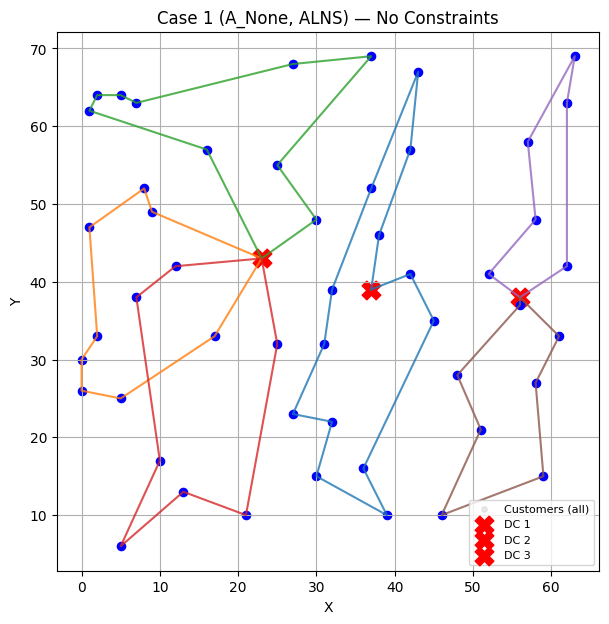

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48260 (\N{HANGUL SYLLABLE BEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


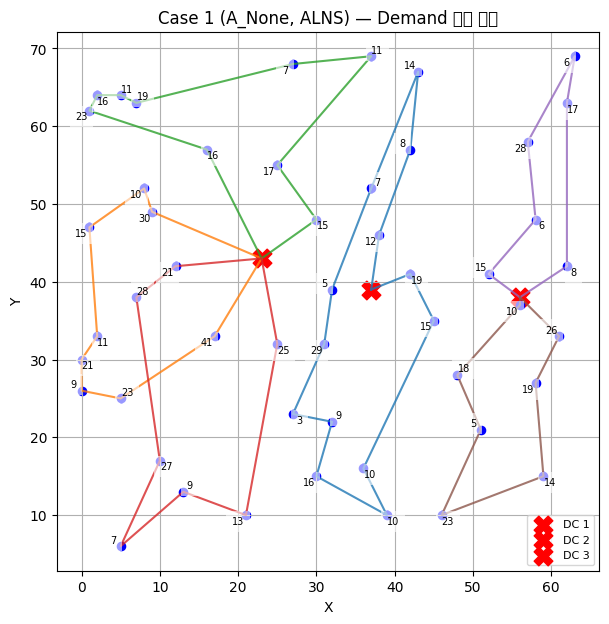

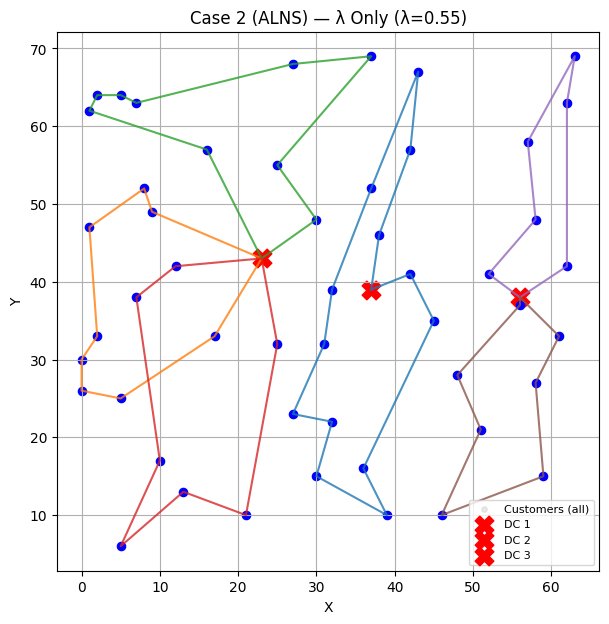

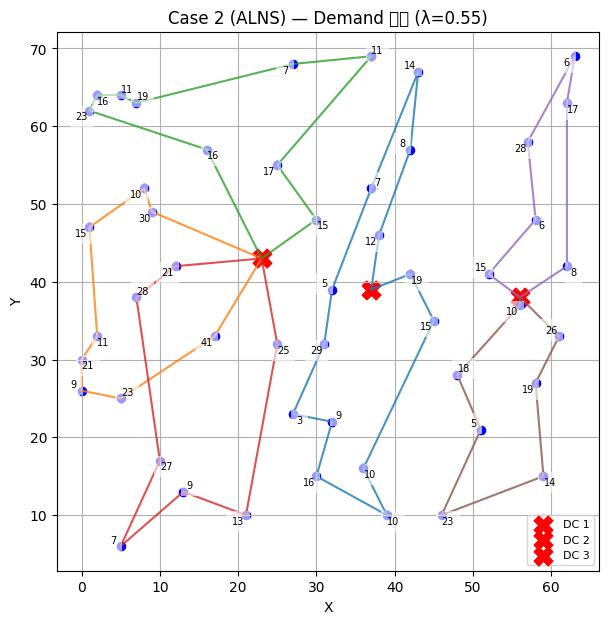

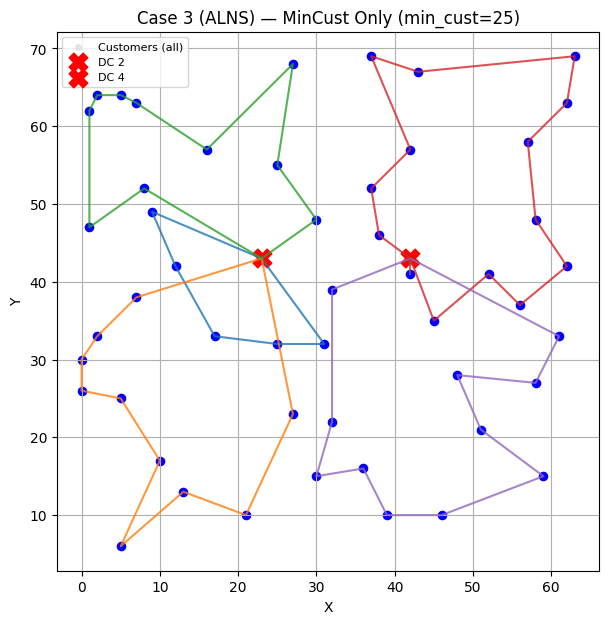

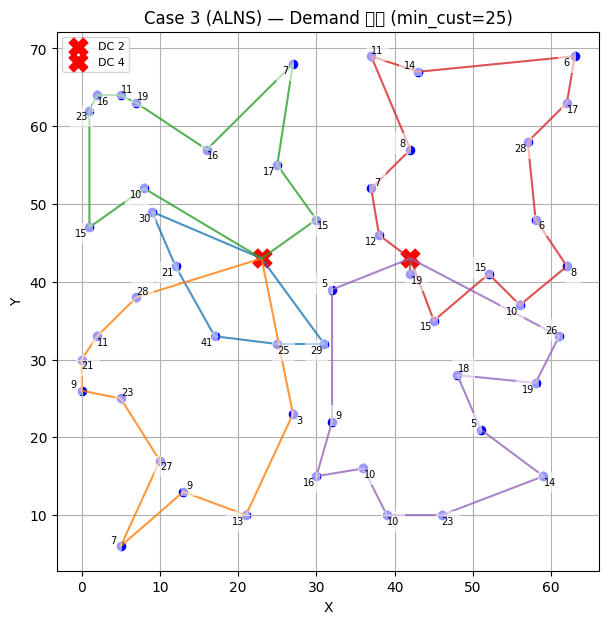

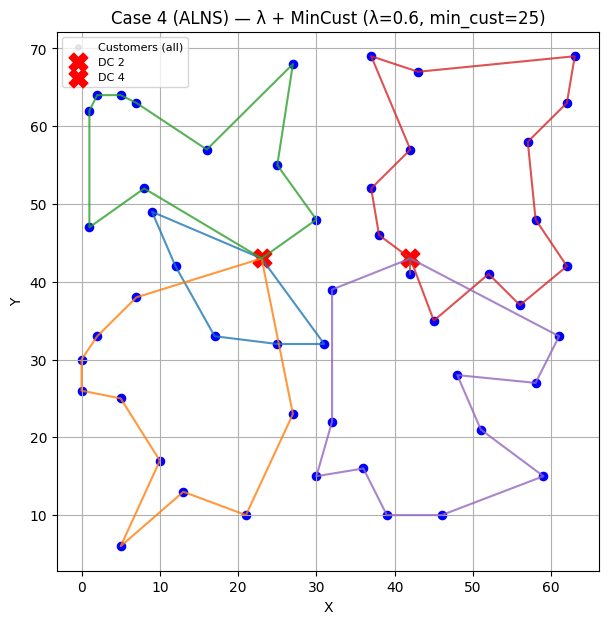

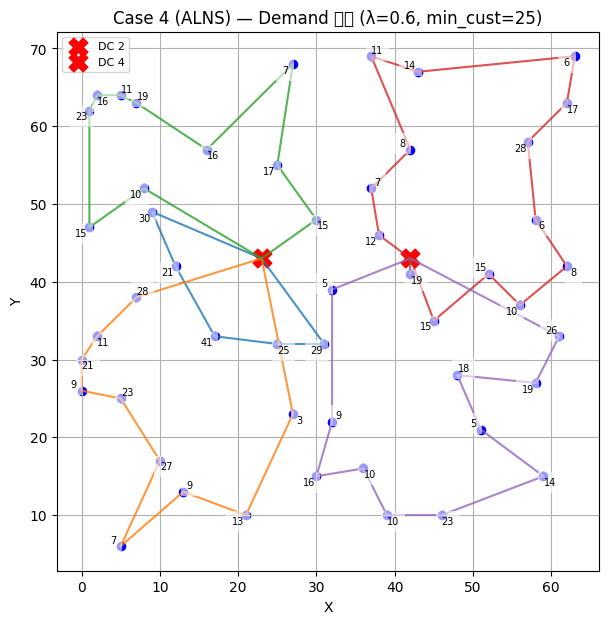

In [2]:
# ================================================================
# 공통 시각화 함수 (CPLEX + ALNS 버전)
#  - plot_case_all_dc           : 경로만 표시
#  - plot_case_all_dc_with_demand : 경로 + 수요(DEMAND) 라벨 한 번씩만 표시
# ================================================================
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1) DC별 경로 전체를 한 그림에 그려주는 버전
# ------------------------------------------------
def plot_case_all_dc(result, title=""):
    """
    result: solve_milp_and_vrp_alns(...)가 반환한 dict
    title : 플롯 제목
    """
    if result is None:
        print(f"[{title}] 결과가 없습니다 (infeasible or failed).")
        return

    routes_detail = result["routes_detail"]
    opened        = result["opened"]

    plt.figure(figsize=(7, 7))

    # 전체 고객 위치를 옅게 찍기 (배경용)
    plt.scatter(customer["X"], customer["Y"],
                c="lightgray", s=15, alpha=0.5, label="Customers (all)")

    for dc_id in opened:
        detail = routes_detail[dc_id]
        routes = detail["routes"]
        locs   = detail["locs"]   # depot + 고객 위치들

        # DC 표시
        x_dc, y_dc = locs[0]
        plt.scatter(x_dc, y_dc, c="red", marker="X", s=180, label=f"DC {dc_id}")

        # 경로 표시
        for r_idx, route in enumerate(routes):
            xs, ys = [], []
            for node in route:
                x, y = locs[node]
                xs.append(x); ys.append(y)

                # 고객 노드면 파란 점으로
                if node != 0:
                    plt.scatter(x, y, c="blue", s=35)
            # 경로 선
            plt.plot(xs, ys, alpha=0.8)

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)

    # 중복 레이블 제거 (DC 여러 개 있을 때)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize=8)

    plt.show()


# ================================================================
# 2) Demand(수요) 라벨을 고객 옆에 "한 번만" 표시하는 시각화 버전
# ================================================================
def plot_case_all_dc_with_demand(result, title=""):
    if result is None:
        print(f"[{title}] 결과가 없습니다 (infeasible or failed).")
        return

    routes_detail = result["routes_detail"]
    opened        = result["opened"]

    plt.figure(figsize=(7, 7))

    # 전체 고객 위치만 옅게 찍기 (텍스트 X)
    plt.scatter(customer["X"], customer["Y"],
                c="lightgray", s=15, alpha=0.5)

    # 이미 라벨 찍은 고객은 다시 안 찍도록 관리
    already_labeled = set()

    for dc_id in opened:
        detail = routes_detail[dc_id]
        routes = detail["routes"]
        locs   = detail["locs"]   # depot + 고객 위치들

        # DC
        x_dc, y_dc = locs[0]
        plt.scatter(x_dc, y_dc, c="red", marker="X", s=180, label=f"DC {dc_id}")

        # 경로 표시
        for r_idx, route in enumerate(routes):
            xs, ys = [], []
            for node in route:
                x, y = locs[node]
                xs.append(x); ys.append(y)

                if node != 0:
                    plt.scatter(x, y, c="blue", s=35)

                    # global customer index
                    # locs: [DC, customer0, customer1, ...]
                    # node==1 → customers[0]
                    global_index = detail["customers"][node-1]

                    # 아직 라벨 안 찍은 고객만 표시
                    if global_index not in already_labeled:
                        d = int(customer.loc[global_index, "DEMAND"])

                        # index에 따라 살짝 다른 방향으로 밀어주기 (겹침 완화)
                        dx = 0.8 if (global_index % 2 == 0) else -1.0
                        dy = 0.8 if (global_index % 3 == 0) else -0.8

                        plt.text(
                            x + dx, y + dy, f"{d}",
                            fontsize=7, color="black",
                            ha="center", va="center",
                            bbox=dict(facecolor="white",
                                      edgecolor="none",
                                      alpha=0.6)
                        )
                        already_labeled.add(global_index)

            plt.plot(xs, ys, alpha=0.8)

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)

    # 중복 레이블 제거
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize=8)

    plt.show()


# ============================
# Case별 2장씩 시각화 호출
# ============================

# ---- Case 1 ----
plot_case_all_dc(
    results_all["A_None"],
    title="Case 1 (A_None, ALNS) — No Constraints"
)

plot_case_all_dc_with_demand(
    results_all["A_None"],
    title="Case 1 (A_None, ALNS) — Demand 표시 버전"
)

# ---- Case 2 ----
plot_case_all_dc(
    results_all["B_LambdaOnly"],
    title=f"Case 2 (ALNS) — λ Only (λ={results_all['B_LambdaOnly']['lambda']})"
)

plot_case_all_dc_with_demand(
    results_all["B_LambdaOnly"],
    title=f"Case 2 (ALNS) — Demand 표시 (λ={results_all['B_LambdaOnly']['lambda']})"
)

# ---- Case 3 ----
plot_case_all_dc(
    results_all["C_MinCustOnly"],
    title=f"Case 3 (ALNS) — MinCust Only (min_cust={results_all['C_MinCustOnly']['min_cust']})"
)

plot_case_all_dc_with_demand(
    results_all["C_MinCustOnly"],
    title=f"Case 3 (ALNS) — Demand 표시 (min_cust={results_all['C_MinCustOnly']['min_cust']})"
)

# ---- Case 4 ----
plot_case_all_dc(
    results_all["D_Both"],
    title=f"Case 4 (ALNS) — λ + MinCust (λ={results_all['D_Both']['lambda']}, min_cust={results_all['D_Both']['min_cust']})"
)

plot_case_all_dc_with_demand(
    results_all["D_Both"],
    title=f"Case 4 (ALNS) — Demand 표시 (λ={results_all['D_Both']['lambda']}, min_cust={results_all['D_Both']['min_cust']})"
)



[A_NoConstraint_ALNS] MILP + ALNS VRP 풀이 시작
  λ = None, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Optimal
개설된 DC: [1, 2, 3]
  DC 1 | ALNS VRP 거리 = 134.39, routes 개수 = 1
  DC 2 | ALNS VRP 거리 = 279.53, routes 개수 = 3
  DC 3 | ALNS VRP 거리 = 143.58, routes 개수 = 2

[A_NoConstraint_ALNS] 결과 요약
  개설된 DC: [1, 2, 3]
  개설비용: 120
  VRP 비용: 557.5029586177579
  총비용: 677.5029586177579


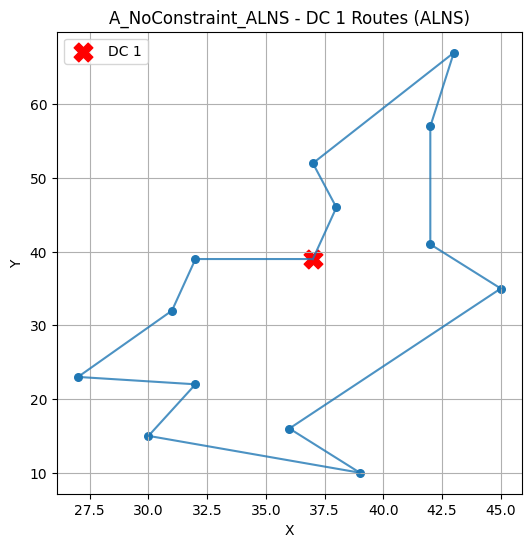

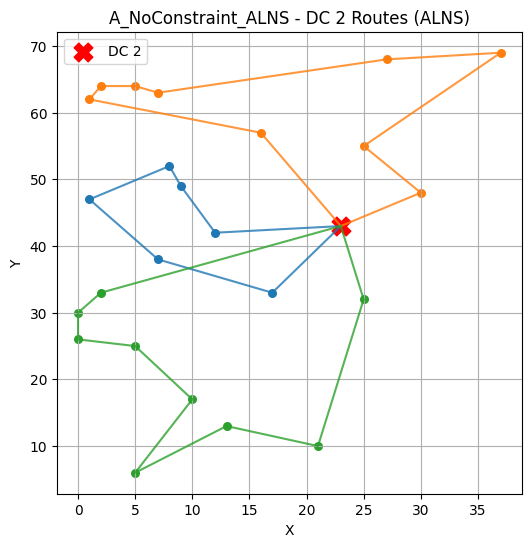

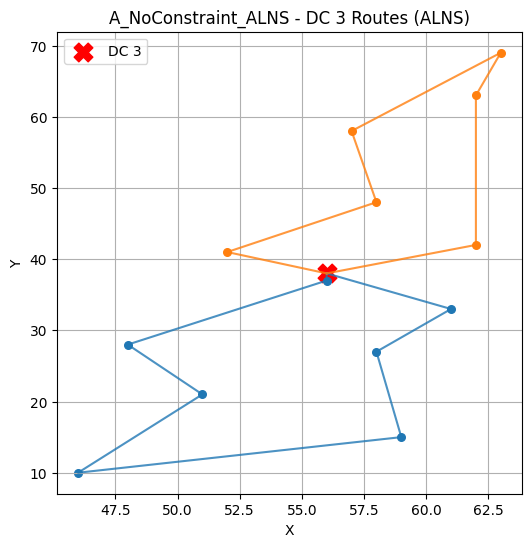


=== B_LambdaOnly — λ grid search (ALNS) ===

[B_LambdaOnly_lam0.1_ALNS] MILP + ALNS VRP 풀이 시작
  λ = 0.1, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Infeasible
 → 최적해를 찾지 못했거나 infeasible 입니다.
  λ=0.10 → infeasible

[B_LambdaOnly_lam0.15_ALNS] MILP + ALNS VRP 풀이 시작
  λ = 0.15, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Infeasible
 → 최적해를 찾지 못했거나 infeasible 입니다.
  λ=0.15 → infeasible

[B_LambdaOnly_lam0.2_ALNS] MILP + ALNS VRP 풀이 시작
  λ = 0.2, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Infeasible
 → 최적해를 찾지 못했거나 infeasible 입니다.
  λ=0.20 → infeasible

[B_LambdaOnly_lam0.25_ALNS] MILP + ALNS VRP 풀이 시작
  λ = 0.25, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Optimal
개설된 DC: [0, 1, 2, 3, 4]
  DC 0 | ALNS VRP 거리 = 127.49, routes 개수 = 2
  DC 1 | ALNS VRP 거리 = 137.81, routes 개수 = 2
  DC 2 | ALNS VRP 거리 = 168.98, routes 개수 = 2
  DC 3 | ALNS VRP 거리 = 127.57, routes 개수 = 2
  DC 4 | ALNS VRP 거리 = 67.29, routes 개수 = 1

[B_LambdaOnly_lam0.25_ALNS] 결과 요약
  개설된 DC:

In [3]:
# =========================================================
# Colab 버전 코드 (CPLEX + ALNS)
# - MILP: PuLP + CPLEX_PY  → DC 개설/배정 (Facility Location)
# - VRP: ALNS 기반 CVRP (트럭 용량 160, depot 복귀)
# - 케이스 A/B/C/D 4개 한 번에 실행
#   * B: λ 자동 탐색
#   * C: min_cust 자동 탐색
#   * D: (λ, min_cust) 그리드 서치
# =========================================================

!pip install pulp cplex --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import pulp

# ---------------------------------------------
# 0) 데이터 로드
# ---------------------------------------------
customer = pd.read_csv("/content/Customer.csv").reset_index().rename(columns={"index": "Customer_ID"})
dc       = pd.read_csv("/content/DistributionCenter.csv").reset_index().rename(columns={"index": "DC_ID"})
truck    = pd.read_csv("/content/Truck.csv")

C = len(customer)   # 고객 수 (예: 50)
D = len(dc)         # DC 수   (예: 5)

TRUCK_CAPACITY = int(truck["CAPACITY"].iloc[0])   # 예: 160
open_cost_j    = dc["COST"].values               # DC 개설비용
dc_capacity_j  = dc["CAPACITY"].values           # DC 보관용량

demand        = customer["DEMAND"].values
total_demand  = demand.sum()

cust_coords = [(customer.loc[i, "X"], customer.loc[i, "Y"]) for i in range(C)]
dc_coords   = [(dc.loc[j, "X"],       dc.loc[j, "Y"])       for j in range(D)]

# ---------------------------------------------
# 1) 유틸 (거리)
# ---------------------------------------------
def euclid(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

# ---------------------------------------------
# 2) ALNS용 CVRP 유틸 함수들 (HEAVY 버전)
#    - route 표현: [0, i1, i2, ..., 0]
#    - demands[0] = 0, 나머지는 고객 수요
# ---------------------------------------------
def compute_route_cost(route, dist_matrix):
    """ route: [0, i1, i2, ..., 0] """
    c = 0.0
    for k in range(len(route) - 1):
        c += dist_matrix[route[k]][route[k+1]]
    return c

def compute_total_cost(routes, dist_matrix):
    return sum(compute_route_cost(r, dist_matrix) for r in routes)

def compute_route_demand(route, demands):
    """ route 안 고객 수요 합 (depot=0은 제외) """
    return sum(demands[node] for node in route if node != 0)

def initial_solution_greedy(demands, dist_matrix, vehicle_capacity, seed=0):
    """
    단순 greedy CVRP 초기해:
    - 고객 순서를 랜덤으로 섞고,
    - 남아 있는 용량이 되는 라우트에 차례대로 넣음
    - 안 들어가면 새 route 생성
    """
    random.seed(seed)
    np.random.seed(seed)

    n = len(demands)  # 0 포함
    customer_ids = list(range(1, n))
    random.shuffle(customer_ids)

    total_demand = sum(demands[1:])
    num_vehicles = max(1, int(np.ceil(total_demand / vehicle_capacity)))

    routes = []
    remaining_cap = []

    for _ in range(num_vehicles):
        routes.append([0, 0])  # depot → depot
        remaining_cap.append(vehicle_capacity)

    for cust in customer_ids:
        d = demands[cust]
        inserted = False
        for r_idx in range(len(routes)):
            if remaining_cap[r_idx] >= d:
                routes[r_idx].insert(-1, cust)
                remaining_cap[r_idx] -= d
                inserted = True
                break
        if not inserted:
            routes.append([0, cust, 0])
            remaining_cap.append(vehicle_capacity - d)

    clean_routes = []
    for r in routes:
        if len(r) > 2:
            clean_routes.append(r)
    if not clean_routes:
        clean_routes = [[0, 0]]

    return clean_routes

# ---------------------------------------------
# 3) ALNS: Destroy 연산자들 (HEAVY)
# ---------------------------------------------
def destroy_random(routes, num_remove, demands=None, dist_matrix=None):
    """
    무작위 고객 제거
    """
    new_routes = copy.deepcopy(routes)
    removed = []

    # 모든 고객 리스트
    all_customers = []
    for r in new_routes:
        for node in r:
            if node != 0:
                all_customers.append(node)

    if not all_customers:
        return new_routes, removed

    random.shuffle(all_customers)
    to_remove = all_customers[:num_remove]

    for cust in to_remove:
        for r in new_routes:
            if cust in r:
                r.remove(cust)
                removed.append(cust)
                break

    # 빈 라우트 제거
    cleaned_routes = []
    for r in new_routes:
        if len(r) > 2:
            cleaned_routes.append(r)
    if not cleaned_routes:
        cleaned_routes = [[0, 0]]

    return cleaned_routes, removed


def destroy_worst(routes, num_remove, demands, dist_matrix):
    """
    '비용에 많이 기여하는' 고객 위주 제거:
    각 고객의 marginal cost를 대략 계산해서 큰 순서대로 제거
    """
    new_routes = copy.deepcopy(routes)
    customer_marginal = []

    for r_idx, r in enumerate(new_routes):
        if len(r) <= 2:
            continue
        for p in range(1, len(r)-1):
            c = r[p]
            prev_node = r[p-1]
            next_node = r[p+1]
            delta = dist_matrix[prev_node][c] + dist_matrix[c][next_node] - dist_matrix[prev_node][next_node]
            customer_marginal.append((c, r_idx, p, delta))

    if not customer_marginal:
        return destroy_random(routes, num_remove, demands, dist_matrix)

    customer_marginal.sort(key=lambda x: x[3], reverse=True)  # delta 큰 순

    removed = []
    used = set()
    for info in customer_marginal:
        c, r_idx, p, delta = info
        if c in used:
            continue
        used.add(c)
        removed.append(c)
        if len(removed) >= num_remove:
            break

    for c in removed:
        for r in new_routes:
            if c in r:
                r.remove(c)
                break

    cleaned_routes = []
    for r in new_routes:
        if len(r) > 2:
            cleaned_routes.append(r)
    if not cleaned_routes:
        cleaned_routes = [[0, 0]]

    return cleaned_routes, removed


def destroy_route(routes, num_remove, demands=None, dist_matrix=None):
    """
    통째로 라우트 하나(또는 일부)를 날리는 destroy
    """
    new_routes = copy.deepcopy(routes)
    non_empty = [idx for idx, r in enumerate(new_routes) if len(r) > 2]
    if not non_empty:
        return destroy_random(routes, num_remove, demands, dist_matrix)

    r_idx = random.choice(non_empty)
    r = new_routes[r_idx]

    customers_in_route = [node for node in r if node != 0]
    random.shuffle(customers_in_route)

    removed = []
    for c in customers_in_route:
        if len(removed) >= num_remove:
            break
        r.remove(c)
        removed.append(c)

    cleaned_routes = []
    for rt in new_routes:
        if len(rt) > 2:
            cleaned_routes.append(rt)
    if not cleaned_routes:
        cleaned_routes = [[0, 0]]

    return cleaned_routes, removed


def destroy_shaw(routes, num_remove, demands, dist_matrix):
    """
    Shaw destroy (유사 고객 묶어서 제거하는 연산자)
    - 거리 기준으로 가까운 고객들을 우선적으로 같이 제거
    """
    new_routes = copy.deepcopy(routes)

    # 모든 고객 모으기
    all_customers = []
    for r in new_routes:
        for node in r:
            if node != 0:
                all_customers.append(node)

    if not all_customers:
        return new_routes, []

    removed = []

    # seed customer 하나 선택
    seed = random.choice(all_customers)
    removed.append(seed)

    # seed 제거
    for r in new_routes:
        if seed in r:
            r.remove(seed)
            break

    # 남은 고객 중 seed와 가까운 애들 위주로 선택
    remaining = [c for c in all_customers if c != seed]

    while len(removed) < num_remove and remaining:
        last = removed[-1]
        # last와의 거리가 가장 가까운 customer 선택
        nearest = min(remaining, key=lambda c: dist_matrix[last][c])
        remaining.remove(nearest)
        removed.append(nearest)
        for r in new_routes:
            if nearest in r:
                r.remove(nearest)
                break

    cleaned_routes = []
    for r in new_routes:
        if len(r) > 2:
            cleaned_routes.append(r)
    if not cleaned_routes:
        cleaned_routes = [[0, 0]]

    return cleaned_routes, removed


# Destroy 연산자 리스트 (4개)
DESTROY_OPERATORS = [
    destroy_random,
    destroy_worst,
    destroy_route,
    destroy_shaw,
]

# ---------------------------------------------
# 4) ALNS: Repair 연산자들 + 2-opt Local Search
# ---------------------------------------------
def insert_feasible_min_cost(routes, cust, demands, dist_matrix, vehicle_capacity):
    """
    한 고객 cust를 capacity 안에서 최소 증가 비용 위치에 삽입
    - 기존 route들 중 feasible한 곳에 넣고
    - feasible한 곳이 하나도 없으면 새 route 생성
    """
    best_cost = float("inf")
    best_r_idx = None
    best_pos = None

    for r_idx, r in enumerate(routes):
        for pos in range(1, len(r)):  # depot 뒤~마지막 노드 앞
            new_route = r[:pos] + [cust] + r[pos:]
            if compute_route_demand(new_route, demands) > vehicle_capacity + 1e-9:
                continue
            delta = compute_route_cost(new_route, dist_matrix) - compute_route_cost(r, dist_matrix)
            if delta < best_cost:
                best_cost = delta
                best_r_idx = r_idx
                best_pos = pos

    if best_r_idx is not None:
        routes[best_r_idx] = routes[best_r_idx][:best_pos] + [cust] + routes[best_r_idx][best_pos:]
        return routes

    # 어디에도 못 넣으면 새 route 생성
    routes.append([0, cust, 0])
    return routes


def repair_greedy(routes, removed, demands, dist_matrix, vehicle_capacity):
    """
    Greedy repair:
    - removed 고객들을 아무 순서대로 순차 삽입
    """
    new_routes = copy.deepcopy(routes)
    for cust in removed:
        new_routes = insert_feasible_min_cost(new_routes, cust, demands, dist_matrix, vehicle_capacity)
    return new_routes


def repair_regret2(routes, removed, demands, dist_matrix, vehicle_capacity):
    """
    Regret-2 기반 repair:
    - 각 고객에 대해 1, 2번째 best 삽입 비용 계산
    - (2번째 - 1번째) regret 값이 큰 고객부터 삽입
    """
    new_routes = copy.deepcopy(routes)
    remaining = set(removed)

    while remaining:
        best_c = None
        best_regret = -1
        best_position_info = None

        for cust in remaining:
            best1 = float("inf")
            best2 = float("inf")
            best1_info = None

            for r_idx, r in enumerate(new_routes):
                for pos in range(1, len(r)):
                    new_route = r[:pos] + [cust] + r[pos:]
                    if compute_route_demand(new_route, demands) > vehicle_capacity + 1e-9:
                        continue
                    delta = compute_route_cost(new_route, dist_matrix) - compute_route_cost(r, dist_matrix)
                    if delta < best1:
                        best2 = best1
                        best1 = delta
                        best1_info = (r_idx, pos)
                    elif delta < best2:
                        best2 = delta

            if best1_info is None:
                # 새 route 만들어서 넣는 delta는 단순 0→cust→0 비용
                delta_new_route = compute_route_cost([0, cust, 0], dist_matrix)
                best1 = delta_new_route
                best2 = delta_new_route
                best1_info = ("new", None)

            regret = best2 - best1
            if regret > best_regret:
                best_regret = regret
                best_c = cust
                best_position_info = (best1_info, best1)

        (r_info, pos), _ = best_position_info
        if r_info == "new":
            new_routes.append([0, best_c, 0])
        else:
            r_idx = r_info
            route = new_routes[r_idx]
            new_routes[r_idx] = route[:pos] + [best_c] + route[pos:]

        remaining.remove(best_c)

    return new_routes

# Repair 연산자 리스트
REPAIR_OPERATORS = [
    repair_greedy,
    repair_regret2,
]

# ---------------------------------------------
# 2-opt Local Search (intra-route)
# ---------------------------------------------
def two_opt_route(route, dist_matrix):
    """
    한 route에 대해 2-opt 로컬 서치 (depot 0 포함)
    """
    best_route = route
    best_cost = compute_route_cost(route, dist_matrix)
    improved = True

    while improved:
        improved = False
        # 1 ~ len-2 사이에서 스왑 (양 끝의 depot(0)은 고정)
        for i in range(1, len(best_route) - 2):
            for j in range(i + 1, len(best_route) - 1):
                if j - i == 1:
                    continue
                new_route = best_route[:i] + best_route[i:j][::-1] + best_route[j:]
                new_cost = compute_route_cost(new_route, dist_matrix)
                if new_cost + 1e-9 < best_cost:
                    best_route = new_route
                    best_cost = new_cost
                    improved = True
        # 개선 없으면 종료
    return best_route


def local_search_2opt(routes, dist_matrix):
    """
    모든 route에 대해 2-opt 한 번씩 적용
    """
    new_routes = []
    for r in routes:
        if len(r) > 3:
            new_routes.append(two_opt_route(r, dist_matrix))
        else:
            new_routes.append(r)
    return new_routes


# ---------------------------------------------
# 5) ALNS 메인 루프 (HEAVY CVRP)
# ---------------------------------------------
def alns_cvrp(demands, dist_matrix, vehicle_capacity,
              max_iter=2000,              # 기본 iteration을 조금 크게
              min_remove_frac=0.2,
              max_remove_frac=0.5,
              reaction_factor=0.2,
              start_temp=1.0,
              end_temp=0.01,
              inner_loops=5,              # 한 iteration에서 여러 후보 생성
              seed=0,
              verbose=False):
    """
    HEAVY ALNS for CVRP (단일 depot)
    - representation: routes = [ [0, ..., 0], ... ]
    - demands[0] = 0
    """

    random.seed(seed)
    np.random.seed(seed)

    # 초기해
    current_routes = initial_solution_greedy(demands, dist_matrix, vehicle_capacity, seed=seed)
    current_routes = local_search_2opt(current_routes, dist_matrix)  # 2-opt로 한 번 정리
    current_cost   = compute_total_cost(current_routes, dist_matrix)

    best_routes = copy.deepcopy(current_routes)
    best_cost   = current_cost

    num_customers = len(demands) - 1

    # destroy / repair operator별 weight / score 초기화
    nD = len(DESTROY_OPERATORS)
    nR = len(REPAIR_OPERATORS)

    destroy_weights = [1.0] * nD
    repair_weights  = [1.0] * nR

    destroy_scores = [0.0] * nD
    repair_scores  = [0.0] * nR

    def select_index(weights):
        s = sum(weights)
        r = random.random() * s
        acc = 0.0
        for i, w in enumerate(weights):
            acc += w
            if r <= acc:
                return i
        return len(weights) - 1

    def temperature(iteration):
        # 선형 cool-down
        return start_temp + (end_temp - start_temp) * (iteration / max_iter)

    if verbose:
        print(f"[ALNS-HEAVY] Initial cost = {best_cost:.2f}, routes = {best_routes}")

    for it in range(1, max_iter+1):
        T = temperature(it)

        # --- 이 iteration에서의 best candidate (inner_loops 중) ---
        iter_best_routes = None
        iter_best_cost   = float("inf")
        iter_best_d_idx  = None
        iter_best_r_idx  = None
        iter_best_improvement = False

        # inner_loops 번 destroy+repair 시도하고 그 중 제일 좋은 후보만 채택 대상으로 사용
        for _ in range(inner_loops):
            # 1) 연산자 선택
            d_idx = select_index(destroy_weights)
            r_idx = select_index(repair_weights)

            destroy_op = DESTROY_OPERATORS[d_idx]
            repair_op  = REPAIR_OPERATORS[r_idx]

            # 동적으로 remove_fraction 결정
            remove_fraction = np.random.uniform(min_remove_frac, max_remove_frac)
            num_remove = max(1, int(num_customers * remove_fraction))

            # 2) Destroy + Repair
            destroyed_routes, removed = destroy_op(current_routes, num_remove, demands, dist_matrix)
            candidate_routes = repair_op(destroyed_routes, removed, demands, dist_matrix, vehicle_capacity)

            # 2-opt local search
            candidate_routes = local_search_2opt(candidate_routes, dist_matrix)
            candidate_cost   = compute_total_cost(candidate_routes, dist_matrix)

            if candidate_cost < iter_best_cost:
                iter_best_cost  = candidate_cost
                iter_best_routes = candidate_routes
                iter_best_d_idx  = d_idx
                iter_best_r_idx  = r_idx
                iter_best_improvement = (candidate_cost < current_cost - 1e-9)

        # --- SA 기반 수용 여부 결정 ---
        if iter_best_routes is None:
            # inner_loops 동안 feasible한 해를 못 만든 경우
            continue

        delta = iter_best_cost - current_cost
        accept = False
        improvement = iter_best_improvement

        if delta < -1e-9:
            accept = True
            improvement = True
        else:
            prob = np.exp(-delta / max(T, 1e-9))
            if random.random() < prob:
                accept = True

        if accept:
            current_routes = iter_best_routes
            current_cost   = iter_best_cost

            d_idx = iter_best_d_idx
            r_idx = iter_best_r_idx

            # best 갱신
            if current_cost < best_cost - 1e-9:
                best_cost = current_cost
                best_routes = copy.deepcopy(current_routes)
                destroy_scores[d_idx] += 4.0
                repair_scores[r_idx]  += 4.0
            elif improvement:
                destroy_scores[d_idx] += 2.0
                repair_scores[r_idx]  += 2.0
            else:
                destroy_scores[d_idx] += 0.5
                repair_scores[r_idx]  += 0.5

        # 4) 주기적으로 weight 업데이트
        if it % 30 == 0:
            for i in range(nD):
                destroy_weights[i] = (1 - reaction_factor) * destroy_weights[i] + reaction_factor * max(destroy_scores[i], 1e-6)
                destroy_scores[i] = 0.0
            for i in range(nR):
                repair_weights[i] = (1 - reaction_factor) * repair_weights[i] + reaction_factor * max(repair_scores[i], 1e-6)
                repair_scores[i] = 0.0

        if verbose and (it % 200 == 0 or it == max_iter):
            print(f"[Iter {it}] current={current_cost:.2f}, best={best_cost:.2f}, T={T:.4f}")

    return best_cost, best_routes


def solve_vrp_alns(demands, dist_matrix, vehicle_capacity,
                   max_iter=2000,
                   remove_fraction=0.3,   # 파라미터는 안 쓰이지만 backward compatibility용
                   seed=0,
                   verbose=False):
    """
    기존 인터페이스 유지용 wrapper
    - 내부적으로는 heavy ALNS(alns_cvrp)를 호출
    """
    cost, routes = alns_cvrp(
        demands=demands,
        dist_matrix=dist_matrix,
        vehicle_capacity=vehicle_capacity,
        max_iter=max_iter,
        min_remove_frac=0.2,
        max_remove_frac=0.5,
        reaction_factor=0.2,
        start_temp=1.0,
        end_temp=0.01,
        inner_loops=5,
        seed=seed,
        verbose=verbose
    )
    return cost, routes


# ---------------------------------------------
# 6) MILP 모델 생성 (CPLEX 그대로)
# ---------------------------------------------
def build_milp_model(lam=None, min_cust=None, use_capacity=True):
    model = pulp.LpProblem("FacilityLocation_Generic", pulp.LpMinimize)

    y = pulp.LpVariable.dicts("OpenDC", range(D), cat="Binary")
    x = pulp.LpVariable.dicts("Assign", (range(C), range(D)), cat="Binary")

    dist_cost = np.zeros((C, D))
    for i in range(C):
        for j in range(D):
            dist_cost[i, j] = euclid(cust_coords[i], dc_coords[j])

    model += (
        pulp.lpSum([y[j] * open_cost_j[j] for j in range(D)]) +
        pulp.lpSum([x[i][j] * dist_cost[i, j] for i in range(C) for j in range(D)])
    )

    for i in range(C):
        model += pulp.lpSum([x[i][j] for j in range(D)]) == 1

    for i in range(C):
        for j in range(D):
            model += x[i][j] <= y[j]

    if lam is not None:
        max_load = lam * total_demand
        for j in range(D):
            model += pulp.lpSum([x[i][j] * demand[i] for i in range(C)]) <= max_load

    if min_cust is not None:
        for j in range(D):
            model += pulp.lpSum([x[i][j] for i in range(C)]) >= min_cust * y[j]

    if use_capacity:
        for j in range(D):
            model += pulp.lpSum([x[i][j] * demand[i] for i in range(C)]) <= dc_capacity_j[j]

    return model, x, y

# ---------------------------------------------
# 7) MILP + ALNS VRP 통합 실행
# ---------------------------------------------
def solve_milp_and_vrp_alns(case_name, lam=None, min_cust=None,
                            use_capacity=True,
                            alns_iter=500,
                            remove_fraction=0.2,
                            cplex_msg=False,
                            do_plot=False):
    print("\n============================")
    print(f"[{case_name}] MILP + ALNS VRP 풀이 시작")
    print(f"  λ = {lam}, MIN_CUST = {min_cust}, CAPACITY_CONSTR = {use_capacity}")
    print("============================")

    model, x, y = build_milp_model(lam=lam, min_cust=min_cust, use_capacity=use_capacity)

    try:
        solver = pulp.CPLEX_PY(msg=cplex_msg)
    except Exception as e:
        raise RuntimeError("CPLEX_PY solver를 사용할 수 없습니다. Colab에서 'pip install cplex'가 성공했는지 확인하세요.") from e

    status = model.solve(solver)
    status_str = pulp.LpStatus[status]
    print("MILP Status:", status_str)
    if status_str != "Optimal":
        print(" → 최적해를 찾지 못했거나 infeasible 입니다.")
        return None

    opened_centers = []
    assignment     = {}

    for j in range(D):
        if y[j].value() > 0.5:
            opened_centers.append(j)

    for i in range(C):
        for j in range(D):
            if x[i][j].value() > 0.5:
                assignment[i] = j
                break

    if len(opened_centers) == 0:
        print(" → 어떤 DC도 열리지 않음 (infeasible 취급)")
        return None

    print("개설된 DC:", opened_centers)

    open_cost_total = sum(open_cost_j[j] for j in opened_centers)

    total_vrp_cost = 0.0
    routes_detail  = {}

    for dc_id in opened_centers:
        cust_list = [i for i in range(C) if assignment[i] == dc_id]
        if not cust_list:
            continue

        # 0: depot, 1~k: 고객
        locs = []
        dc_row = dc.loc[dc_id]
        locs.append((dc_row["X"], dc_row["Y"]))
        for cid in cust_list:
            crow = customer.loc[cid]
            locs.append((crow["X"], crow["Y"]))

        n = len(locs)
        dist_matrix = [[euclid(locs[i], locs[j]) for j in range(n)] for i in range(n)]
        demands_local = [0] + [int(demand[cid]) for cid in cust_list]

        vrp_dist, routes = solve_vrp_alns(
            demands=demands_local,
            dist_matrix=dist_matrix,
            vehicle_capacity=TRUCK_CAPACITY,
            max_iter=alns_iter,
            remove_fraction=remove_fraction,
            seed=dc_id,          # DC마다 seed 다르게
            verbose=False
        )

        total_vrp_cost += vrp_dist
        routes_detail[dc_id] = {
            "routes": routes,
            "locs":  locs,
            "customers": cust_list
        }

        print(f"  DC {dc_id} | ALNS VRP 거리 = {vrp_dist:.2f}, routes 개수 = {len(routes)}")

    total_cost = open_cost_total + total_vrp_cost

    print(f"\n[{case_name}] 결과 요약")
    print("  개설된 DC:", opened_centers)
    print("  개설비용:", open_cost_total)
    print("  VRP 비용:", total_vrp_cost)
    print("  총비용:", total_cost)

    if do_plot:
        for dc_id in opened_centers:
            detail = routes_detail[dc_id]
            routes = detail["routes"]
            locs   = detail["locs"]

            plt.figure(figsize=(6,6))
            x_dc, y_dc = locs[0]
            plt.scatter(x_dc, y_dc, c="red", marker="X", s=180, label=f"DC {dc_id}")

            colors = ["tab:blue", "tab:orange", "tab:green", "tab:red",
                      "tab:purple", "tab:brown", "tab:pink", "tab:gray"]
            for r_idx, route in enumerate(routes):
                xs, ys = [], []
                for node in route:
                    x, y = locs[node]
                    xs.append(x); ys.append(y)
                    if node != 0:
                        plt.scatter(x, y, c=colors[r_idx % len(colors)], s=30)
                plt.plot(xs, ys, c=colors[r_idx % len(colors)], alpha=0.8)

            plt.title(f"{case_name} - DC {dc_id} Routes (ALNS)")
            plt.xlabel("X"); plt.ylabel("Y")
            plt.grid(True); plt.legend()
            plt.show()

    result = {
        "case": case_name,
        "lambda": lam,
        "min_cust": min_cust,
        "opened": opened_centers,
        "open_cost": open_cost_total,
        "vrp_cost": total_vrp_cost,
        "total_cost": total_cost,
        "routes_detail": routes_detail,
        "assignment": assignment
    }
    return result

# ---------------------------------------------
# 8) λ / min_cust 후보 자동 생성
# ---------------------------------------------
def lambda_candidates():
    return [round(0.10 + 0.05 * k, 2) for k in range(0, 17)]

def min_cust_candidates():
    step = max(1, C // 10)
    max_val = max(step, C // 2)
    return list(range(step, max_val + 1, step))

# ---------------------------------------------
# 9) 4가지 케이스 한 번에 실행 (ALNS 버전)
# ---------------------------------------------
results_all = {}

# 공통 세팅
ALNS_ITER = 500
REMOVE_FRAC = 0.2

# A. 제약 없음
results_all["A_None"] = solve_milp_and_vrp_alns(
    case_name="A_NoConstraint_ALNS",
    lam=None,
    min_cust=None,
    use_capacity=True,
    alns_iter=ALNS_ITER,
    remove_fraction=REMOVE_FRAC,
    do_plot=True
)

# B. 제약 1만 (λ)
print("\n=== B_LambdaOnly — λ grid search (ALNS) ===")
best_B = None
for lam in lambda_candidates():
    res = solve_milp_and_vrp_alns(
        case_name=f"B_LambdaOnly_lam{lam}_ALNS",
        lam=lam,
        min_cust=None,
        use_capacity=True,
        alns_iter=ALNS_ITER,
        remove_fraction=REMOVE_FRAC,
        do_plot=False
    )
    if res is None:
        print(f"  λ={lam:.2f} → infeasible")
        continue
    print(f"  λ={lam:.2f} → TOTAL={res['total_cost']:.2f}, opened={res['opened']}")
    if (best_B is None) or (res["total_cost"] < best_B["total_cost"]):
        best_B = res
results_all["B_LambdaOnly"] = best_B

# C. 제약 2만 (MIN_CUST)
print("\n=== C_MinCustOnly — min_cust grid search (ALNS) ===")
best_C = None
for mc in min_cust_candidates():
    res = solve_milp_and_vrp_alns(
        case_name=f"C_MinCustOnly_mc{mc}_ALNS",
        lam=None,
        min_cust=mc,
        use_capacity=True,
        alns_iter=ALNS_ITER,
        remove_fraction=REMOVE_FRAC,
        do_plot=False
    )
    if res is None:
        print(f"  min_cust={mc} → infeasible")
        continue
    print(f"  min_cust={mc} → TOTAL={res['total_cost']:.2f}, opened={res['opened']}")
    if (best_C is None) or (res["total_cost"] < best_C["total_cost"]):
        best_C = res
results_all["C_MinCustOnly"] = best_C

# D. 제약 1+2 동시 적용
print("\n=== D_Both — (λ, min_cust) grid search (ALNS) ===")
best_D = None
for lam in lambda_candidates():
    for mc in min_cust_candidates():
        res = solve_milp_and_vrp_alns(
            case_name=f"D_Both_lam{lam}_mc{mc}_ALNS",
            lam=lam,
            min_cust=mc,
            use_capacity=True,
            alns_iter=ALNS_ITER,
            remove_fraction=REMOVE_FRAC,
            do_plot=False
        )
        if res is None:
            print(f"  λ={lam:.2f}, min_cust={mc} → infeasible")
            continue
        print(f"  λ={lam:.2f}, min_cust={mc} → TOTAL={res['total_cost']:.2f}, opened={res['opened']}")
        if (best_D is None) or (res["total_cost"] < best_D["total_cost"]):
            best_D = res
results_all["D_Both"] = best_D

# ---------------------------------------------
# 10) 최종 비교 출력
# ---------------------------------------------
print("\n================ 최종 비교 (CPLEX + ALNS) ================")
for k, res in results_all.items():
    if res is None:
        print(k, "→ infeasible or failed")
    else:
        print(
            f"{k}: TOTAL={res['total_cost']:.2f}, opened={res['opened']}, "
            f"λ={res['lambda']}, min_cust={res['min_cust']}"
        )
print("=========================================================")


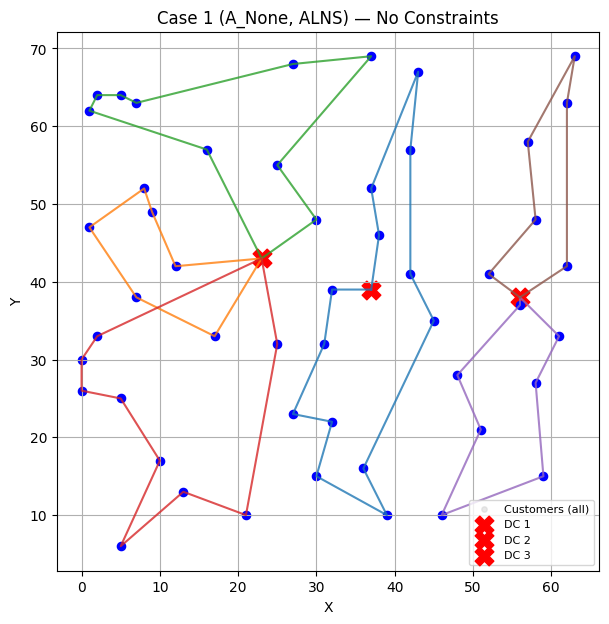

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48260 (\N{HANGUL SYLLABLE BEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


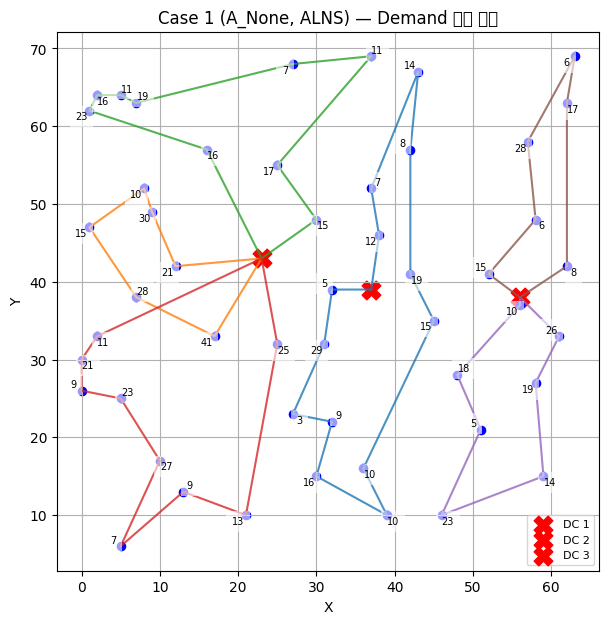

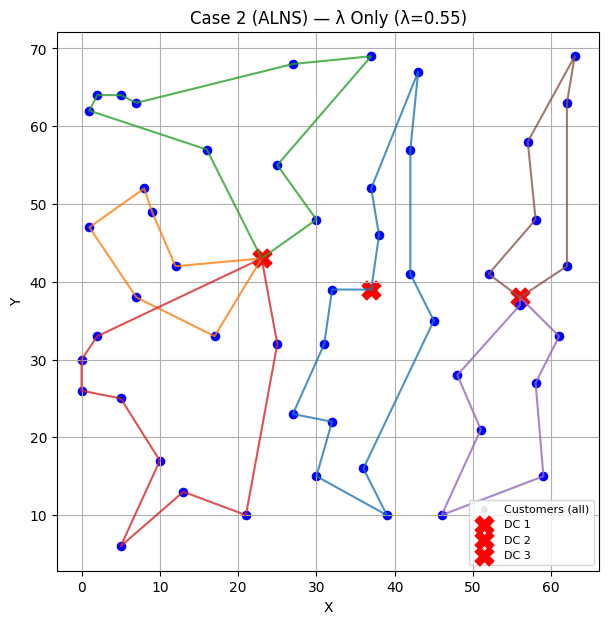

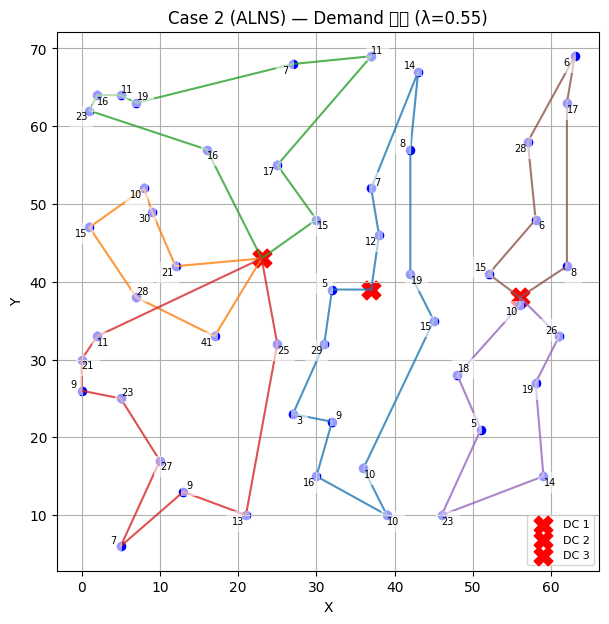

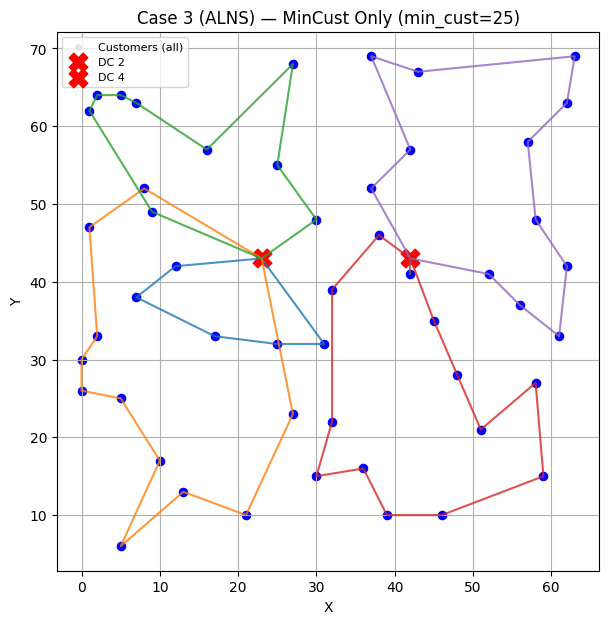

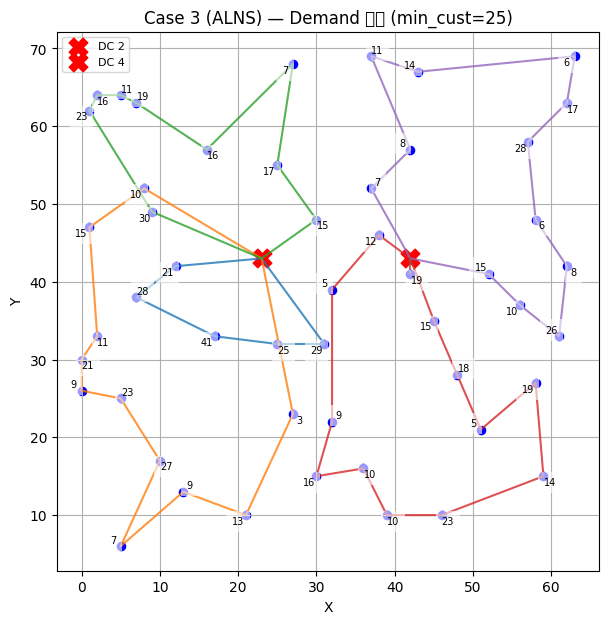

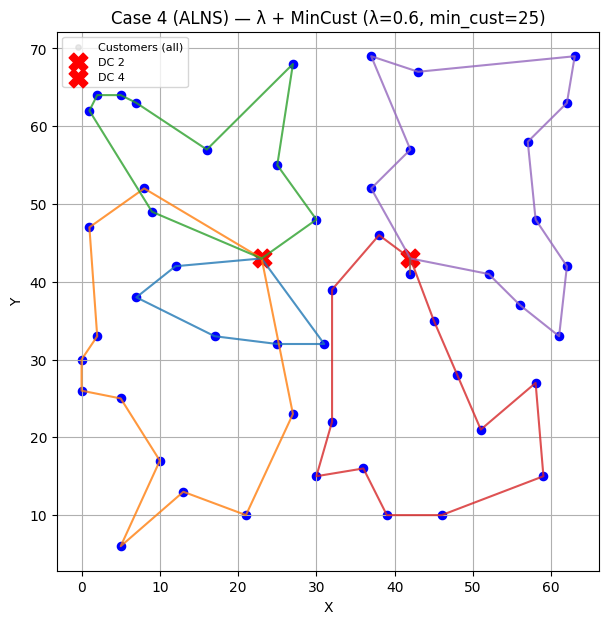

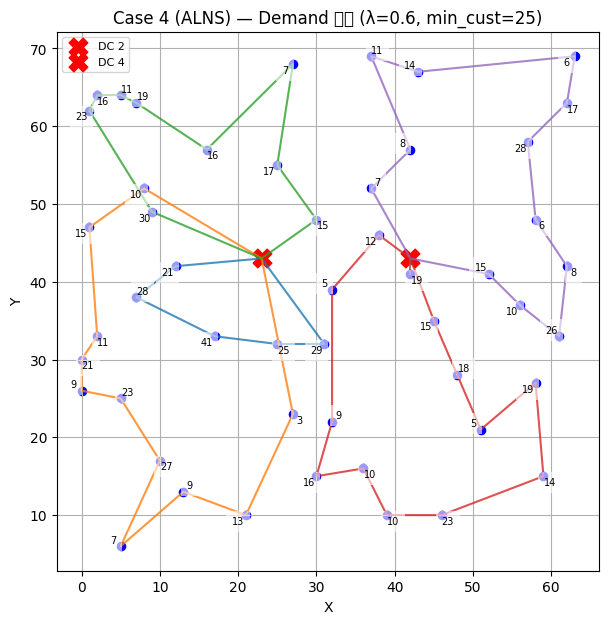

In [4]:
# ================================================================
# 공통 시각화 함수 (CPLEX + ALNS 버전)
#  - plot_case_all_dc           : 경로만 표시
#  - plot_case_all_dc_with_demand : 경로 + 수요(DEMAND) 라벨 한 번씩만 표시
# ================================================================
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1) DC별 경로 전체를 한 그림에 그려주는 버전
# ------------------------------------------------
def plot_case_all_dc(result, title=""):
    """
    result: solve_milp_and_vrp_alns(...)가 반환한 dict
    title : 플롯 제목
    """
    if result is None:
        print(f"[{title}] 결과가 없습니다 (infeasible or failed).")
        return

    routes_detail = result["routes_detail"]
    opened        = result["opened"]

    plt.figure(figsize=(7, 7))

    # 전체 고객 위치를 옅게 찍기 (배경용)
    plt.scatter(customer["X"], customer["Y"],
                c="lightgray", s=15, alpha=0.5, label="Customers (all)")

    for dc_id in opened:
        detail = routes_detail[dc_id]
        routes = detail["routes"]
        locs   = detail["locs"]   # depot + 고객 위치들

        # DC 표시
        x_dc, y_dc = locs[0]
        plt.scatter(x_dc, y_dc, c="red", marker="X", s=180, label=f"DC {dc_id}")

        # 경로 표시
        for r_idx, route in enumerate(routes):
            xs, ys = [], []
            for node in route:
                x, y = locs[node]
                xs.append(x); ys.append(y)

                # 고객 노드면 파란 점으로
                if node != 0:
                    plt.scatter(x, y, c="blue", s=35)
            # 경로 선
            plt.plot(xs, ys, alpha=0.8)

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)

    # 중복 레이블 제거 (DC 여러 개 있을 때)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize=8)

    plt.show()


# ================================================================
# 2) Demand(수요) 라벨을 고객 옆에 "한 번만" 표시하는 시각화 버전
# ================================================================
def plot_case_all_dc_with_demand(result, title=""):
    if result is None:
        print(f"[{title}] 결과가 없습니다 (infeasible or failed).")
        return

    routes_detail = result["routes_detail"]
    opened        = result["opened"]

    plt.figure(figsize=(7, 7))

    # 전체 고객 위치만 옅게 찍기 (텍스트 X)
    plt.scatter(customer["X"], customer["Y"],
                c="lightgray", s=15, alpha=0.5)

    # 이미 라벨 찍은 고객은 다시 안 찍도록 관리
    already_labeled = set()

    for dc_id in opened:
        detail = routes_detail[dc_id]
        routes = detail["routes"]
        locs   = detail["locs"]   # depot + 고객 위치들

        # DC
        x_dc, y_dc = locs[0]
        plt.scatter(x_dc, y_dc, c="red", marker="X", s=180, label=f"DC {dc_id}")

        # 경로 표시
        for r_idx, route in enumerate(routes):
            xs, ys = [], []
            for node in route:
                x, y = locs[node]
                xs.append(x); ys.append(y)

                if node != 0:
                    plt.scatter(x, y, c="blue", s=35)

                    # global customer index
                    # locs: [DC, customer0, customer1, ...]
                    # node==1 → customers[0]
                    global_index = detail["customers"][node-1]

                    # 아직 라벨 안 찍은 고객만 표시
                    if global_index not in already_labeled:
                        d = int(customer.loc[global_index, "DEMAND"])

                        # index에 따라 살짝 다른 방향으로 밀어주기 (겹침 완화)
                        dx = 0.8 if (global_index % 2 == 0) else -1.0
                        dy = 0.8 if (global_index % 3 == 0) else -0.8

                        plt.text(
                            x + dx, y + dy, f"{d}",
                            fontsize=7, color="black",
                            ha="center", va="center",
                            bbox=dict(facecolor="white",
                                      edgecolor="none",
                                      alpha=0.6)
                        )
                        already_labeled.add(global_index)

            plt.plot(xs, ys, alpha=0.8)

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)

    # 중복 레이블 제거
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize=8)

    plt.show()


# ============================
# Case별 2장씩 시각화 호출
# ============================

# ---- Case 1 ----
plot_case_all_dc(
    results_all["A_None"],
    title="Case 1 (A_None, ALNS) — No Constraints"
)

plot_case_all_dc_with_demand(
    results_all["A_None"],
    title="Case 1 (A_None, ALNS) — Demand 표시 버전"
)

# ---- Case 2 ----
plot_case_all_dc(
    results_all["B_LambdaOnly"],
    title=f"Case 2 (ALNS) — λ Only (λ={results_all['B_LambdaOnly']['lambda']})"
)

plot_case_all_dc_with_demand(
    results_all["B_LambdaOnly"],
    title=f"Case 2 (ALNS) — Demand 표시 (λ={results_all['B_LambdaOnly']['lambda']})"
)

# ---- Case 3 ----
plot_case_all_dc(
    results_all["C_MinCustOnly"],
    title=f"Case 3 (ALNS) — MinCust Only (min_cust={results_all['C_MinCustOnly']['min_cust']})"
)

plot_case_all_dc_with_demand(
    results_all["C_MinCustOnly"],
    title=f"Case 3 (ALNS) — Demand 표시 (min_cust={results_all['C_MinCustOnly']['min_cust']})"
)

# ---- Case 4 ----
plot_case_all_dc(
    results_all["D_Both"],
    title=f"Case 4 (ALNS) — λ + MinCust (λ={results_all['D_Both']['lambda']}, min_cust={results_all['D_Both']['min_cust']})"
)

plot_case_all_dc_with_demand(
    results_all["D_Both"],
    title=f"Case 4 (ALNS) — Demand 표시 (λ={results_all['D_Both']['lambda']}, min_cust={results_all['D_Both']['min_cust']})"
)



[A_NoConstraint_ALNS] MILP + ALNS VRP 풀이 시작
  λ = None, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Optimal
개설된 DC: [1, 2, 3]
  DC 1 | ALNS VRP 거리 = 134.39, routes 개수 = 1
  DC 2 | ALNS VRP 거리 = 279.53, routes 개수 = 3
  DC 3 | ALNS VRP 거리 = 143.58, routes 개수 = 2

[A_NoConstraint_ALNS] 결과 요약
  개설된 DC: [1, 2, 3]
  개설비용: 120
  VRP 비용: 557.5029586177579
  총비용: 677.5029586177579


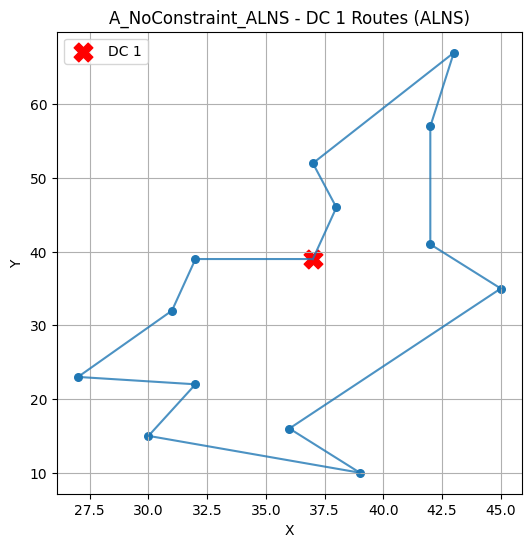

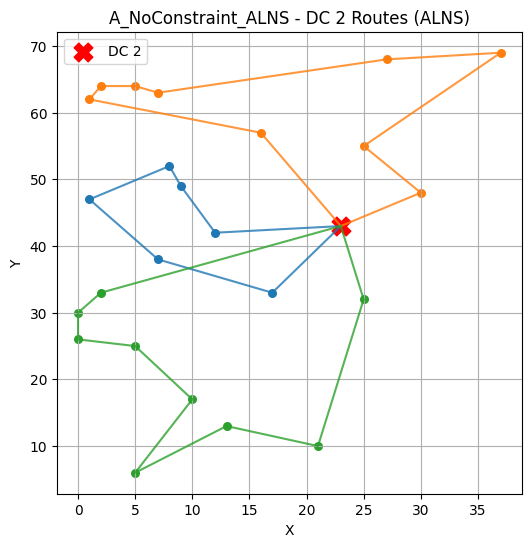

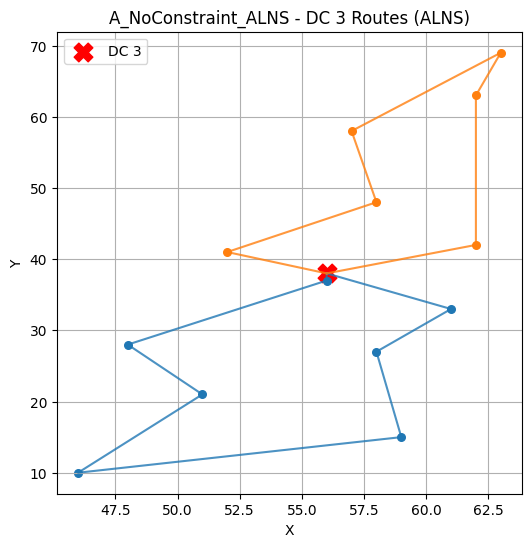


=== B_LambdaOnly — λ grid search (ALNS) ===

[B_LambdaOnly_lam0.1_ALNS] MILP + ALNS VRP 풀이 시작
  λ = 0.1, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Infeasible
 → 최적해를 찾지 못했거나 infeasible 입니다.
  λ=0.10 → infeasible

[B_LambdaOnly_lam0.15_ALNS] MILP + ALNS VRP 풀이 시작
  λ = 0.15, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Infeasible
 → 최적해를 찾지 못했거나 infeasible 입니다.
  λ=0.15 → infeasible

[B_LambdaOnly_lam0.2_ALNS] MILP + ALNS VRP 풀이 시작
  λ = 0.2, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Infeasible
 → 최적해를 찾지 못했거나 infeasible 입니다.
  λ=0.20 → infeasible

[B_LambdaOnly_lam0.25_ALNS] MILP + ALNS VRP 풀이 시작
  λ = 0.25, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Optimal
개설된 DC: [0, 1, 2, 3, 4]
  DC 0 | ALNS VRP 거리 = 127.49, routes 개수 = 2
  DC 1 | ALNS VRP 거리 = 137.81, routes 개수 = 2
  DC 2 | ALNS VRP 거리 = 168.98, routes 개수 = 2
  DC 3 | ALNS VRP 거리 = 127.57, routes 개수 = 2
  DC 4 | ALNS VRP 거리 = 67.29, routes 개수 = 1

[B_LambdaOnly_lam0.25_ALNS] 결과 요약
  개설된 DC:

In [5]:
# =========================================================
# Colab 버전 코드 (CPLEX + ALNS)
# - MILP: PuLP + CPLEX_PY  → DC 개설/배정 (Facility Location)
# - VRP: ALNS 기반 CVRP (트럭 용량 160, depot 복귀)
# - 케이스 A/B/C/D 4개 한 번에 실행
#   * B: λ 자동 탐색
#   * C: min_cust 자동 탐색
#   * D: (λ, min_cust) 그리드 서치
# =========================================================

!pip install pulp cplex --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import pulp

# ---------------------------------------------
# 0) 데이터 로드
# ---------------------------------------------
customer = pd.read_csv("/content/Customer.csv").reset_index().rename(columns={"index": "Customer_ID"})
dc       = pd.read_csv("/content/DistributionCenter.csv").reset_index().rename(columns={"index": "DC_ID"})
truck    = pd.read_csv("/content/Truck.csv")

C = len(customer)   # 고객 수 (예: 50)
D = len(dc)         # DC 수   (예: 5)

TRUCK_CAPACITY = int(truck["CAPACITY"].iloc[0])   # 예: 160
open_cost_j    = dc["COST"].values               # DC 개설비용
dc_capacity_j  = dc["CAPACITY"].values           # DC 보관용량

demand        = customer["DEMAND"].values
total_demand  = demand.sum()

cust_coords = [(customer.loc[i, "X"], customer.loc[i, "Y"]) for i in range(C)]
dc_coords   = [(dc.loc[j, "X"],       dc.loc[j, "Y"])       for j in range(D)]

# ---------------------------------------------
# 1) 유틸 (거리)
# ---------------------------------------------
def euclid(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

# ---------------------------------------------
# 2) ALNS용 CVRP 유틸 함수들 (HEAVY 버전)
#    - route 표현: [0, i1, i2, ..., 0]
#    - demands[0] = 0, 나머지는 고객 수요
# ---------------------------------------------
def compute_route_cost(route, dist_matrix):
    """ route: [0, i1, i2, ..., 0] """
    c = 0.0
    for k in range(len(route) - 1):
        c += dist_matrix[route[k]][route[k+1]]
    return c

def compute_total_cost(routes, dist_matrix):
    return sum(compute_route_cost(r, dist_matrix) for r in routes)

def compute_route_demand(route, demands):
    """ route 안 고객 수요 합 (depot=0은 제외) """
    return sum(demands[node] for node in route if node != 0)

def initial_solution_greedy(demands, dist_matrix, vehicle_capacity, seed=0):
    """
    단순 greedy CVRP 초기해:
    - 고객 순서를 랜덤으로 섞고,
    - 남아 있는 용량이 되는 라우트에 차례대로 넣음
    - 안 들어가면 새 route 생성
    """
    random.seed(seed)
    np.random.seed(seed)

    n = len(demands)  # 0 포함
    customer_ids = list(range(1, n))
    random.shuffle(customer_ids)

    total_demand = sum(demands[1:])
    num_vehicles = max(1, int(np.ceil(total_demand / vehicle_capacity)))

    routes = []
    remaining_cap = []

    for _ in range(num_vehicles):
        routes.append([0, 0])  # depot → depot
        remaining_cap.append(vehicle_capacity)

    for cust in customer_ids:
        d = demands[cust]
        inserted = False
        for r_idx in range(len(routes)):
            if remaining_cap[r_idx] >= d:
                routes[r_idx].insert(-1, cust)
                remaining_cap[r_idx] -= d
                inserted = True
                break
        if not inserted:
            routes.append([0, cust, 0])
            remaining_cap.append(vehicle_capacity - d)

    clean_routes = []
    for r in routes:
        if len(r) > 2:
            clean_routes.append(r)
    if not clean_routes:
        clean_routes = [[0, 0]]

    return clean_routes

# ---------------------------------------------
# 3) ALNS: Destroy 연산자들 (HEAVY)
# ---------------------------------------------
def destroy_random(routes, num_remove, demands=None, dist_matrix=None):
    """
    무작위 고객 제거
    """
    new_routes = copy.deepcopy(routes)
    removed = []

    # 모든 고객 리스트
    all_customers = []
    for r in new_routes:
        for node in r:
            if node != 0:
                all_customers.append(node)

    if not all_customers:
        return new_routes, removed

    random.shuffle(all_customers)
    to_remove = all_customers[:num_remove]

    for cust in to_remove:
        for r in new_routes:
            if cust in r:
                r.remove(cust)
                removed.append(cust)
                break

    # 빈 라우트 제거
    cleaned_routes = []
    for r in new_routes:
        if len(r) > 2:
            cleaned_routes.append(r)
    if not cleaned_routes:
        cleaned_routes = [[0, 0]]

    return cleaned_routes, removed


def destroy_worst(routes, num_remove, demands, dist_matrix):
    """
    '비용에 많이 기여하는' 고객 위주 제거:
    각 고객의 marginal cost를 대략 계산해서 큰 순서대로 제거
    """
    new_routes = copy.deepcopy(routes)
    customer_marginal = []

    for r_idx, r in enumerate(new_routes):
        if len(r) <= 2:
            continue
        for p in range(1, len(r)-1):
            c = r[p]
            prev_node = r[p-1]
            next_node = r[p+1]
            delta = dist_matrix[prev_node][c] + dist_matrix[c][next_node] - dist_matrix[prev_node][next_node]
            customer_marginal.append((c, r_idx, p, delta))

    if not customer_marginal:
        return destroy_random(routes, num_remove, demands, dist_matrix)

    customer_marginal.sort(key=lambda x: x[3], reverse=True)  # delta 큰 순

    removed = []
    used = set()
    for info in customer_marginal:
        c, r_idx, p, delta = info
        if c in used:
            continue
        used.add(c)
        removed.append(c)
        if len(removed) >= num_remove:
            break

    for c in removed:
        for r in new_routes:
            if c in r:
                r.remove(c)
                break

    cleaned_routes = []
    for r in new_routes:
        if len(r) > 2:
            cleaned_routes.append(r)
    if not cleaned_routes:
        cleaned_routes = [[0, 0]]

    return cleaned_routes, removed


def destroy_route(routes, num_remove, demands=None, dist_matrix=None):
    """
    통째로 라우트 하나(또는 일부)를 날리는 destroy
    """
    new_routes = copy.deepcopy(routes)
    non_empty = [idx for idx, r in enumerate(new_routes) if len(r) > 2]
    if not non_empty:
        return destroy_random(routes, num_remove, demands, dist_matrix)

    r_idx = random.choice(non_empty)
    r = new_routes[r_idx]

    customers_in_route = [node for node in r if node != 0]
    random.shuffle(customers_in_route)

    removed = []
    for c in customers_in_route:
        if len(removed) >= num_remove:
            break
        r.remove(c)
        removed.append(c)

    cleaned_routes = []
    for rt in new_routes:
        if len(rt) > 2:
            cleaned_routes.append(rt)
    if not cleaned_routes:
        cleaned_routes = [[0, 0]]

    return cleaned_routes, removed


def destroy_shaw(routes, num_remove, demands, dist_matrix):
    """
    Shaw destroy (유사 고객 묶어서 제거하는 연산자)
    - 거리 기준으로 가까운 고객들을 우선적으로 같이 제거
    """
    new_routes = copy.deepcopy(routes)

    # 모든 고객 모으기
    all_customers = []
    for r in new_routes:
        for node in r:
            if node != 0:
                all_customers.append(node)

    if not all_customers:
        return new_routes, []

    removed = []

    # seed customer 하나 선택
    seed = random.choice(all_customers)
    removed.append(seed)

    # seed 제거
    for r in new_routes:
        if seed in r:
            r.remove(seed)
            break

    # 남은 고객 중 seed와 가까운 애들 위주로 선택
    remaining = [c for c in all_customers if c != seed]

    while len(removed) < num_remove and remaining:
        last = removed[-1]
        # last와의 거리가 가장 가까운 customer 선택
        nearest = min(remaining, key=lambda c: dist_matrix[last][c])
        remaining.remove(nearest)
        removed.append(nearest)
        for r in new_routes:
            if nearest in r:
                r.remove(nearest)
                break

    cleaned_routes = []
    for r in new_routes:
        if len(r) > 2:
            cleaned_routes.append(r)
    if not cleaned_routes:
        cleaned_routes = [[0, 0]]

    return cleaned_routes, removed


# Destroy 연산자 리스트 (4개)
DESTROY_OPERATORS = [
    destroy_random,
    destroy_worst,
    destroy_route,
    destroy_shaw,
]

# ---------------------------------------------
# 4) ALNS: Repair 연산자들 + 2-opt Local Search
# ---------------------------------------------
def insert_feasible_min_cost(routes, cust, demands, dist_matrix, vehicle_capacity):
    """
    한 고객 cust를 capacity 안에서 최소 증가 비용 위치에 삽입
    - 기존 route들 중 feasible한 곳에 넣고
    - feasible한 곳이 하나도 없으면 새 route 생성
    """
    best_cost = float("inf")
    best_r_idx = None
    best_pos = None

    for r_idx, r in enumerate(routes):
        for pos in range(1, len(r)):  # depot 뒤~마지막 노드 앞
            new_route = r[:pos] + [cust] + r[pos:]
            if compute_route_demand(new_route, demands) > vehicle_capacity + 1e-9:
                continue
            delta = compute_route_cost(new_route, dist_matrix) - compute_route_cost(r, dist_matrix)
            if delta < best_cost:
                best_cost = delta
                best_r_idx = r_idx
                best_pos = pos

    if best_r_idx is not None:
        routes[best_r_idx] = routes[best_r_idx][:best_pos] + [cust] + routes[best_r_idx][best_pos:]
        return routes

    # 어디에도 못 넣으면 새 route 생성
    routes.append([0, cust, 0])
    return routes


def repair_greedy(routes, removed, demands, dist_matrix, vehicle_capacity):
    """
    Greedy repair:
    - removed 고객들을 아무 순서대로 순차 삽입
    """
    new_routes = copy.deepcopy(routes)
    for cust in removed:
        new_routes = insert_feasible_min_cost(new_routes, cust, demands, dist_matrix, vehicle_capacity)
    return new_routes


def repair_regret2(routes, removed, demands, dist_matrix, vehicle_capacity):
    """
    Regret-2 기반 repair:
    - 각 고객에 대해 1, 2번째 best 삽입 비용 계산
    - (2번째 - 1번째) regret 값이 큰 고객부터 삽입
    """
    new_routes = copy.deepcopy(routes)
    remaining = set(removed)

    while remaining:
        best_c = None
        best_regret = -1
        best_position_info = None

        for cust in remaining:
            best1 = float("inf")
            best2 = float("inf")
            best1_info = None

            for r_idx, r in enumerate(new_routes):
                for pos in range(1, len(r)):
                    new_route = r[:pos] + [cust] + r[pos:]
                    if compute_route_demand(new_route, demands) > vehicle_capacity + 1e-9:
                        continue
                    delta = compute_route_cost(new_route, dist_matrix) - compute_route_cost(r, dist_matrix)
                    if delta < best1:
                        best2 = best1
                        best1 = delta
                        best1_info = (r_idx, pos)
                    elif delta < best2:
                        best2 = delta

            if best1_info is None:
                # 새 route 만들어서 넣는 delta는 단순 0→cust→0 비용
                delta_new_route = compute_route_cost([0, cust, 0], dist_matrix)
                best1 = delta_new_route
                best2 = delta_new_route
                best1_info = ("new", None)

            regret = best2 - best1
            if regret > best_regret:
                best_regret = regret
                best_c = cust
                best_position_info = (best1_info, best1)

        (r_info, pos), _ = best_position_info
        if r_info == "new":
            new_routes.append([0, best_c, 0])
        else:
            r_idx = r_info
            route = new_routes[r_idx]
            new_routes[r_idx] = route[:pos] + [best_c] + route[pos:]

        remaining.remove(best_c)

    return new_routes

# Repair 연산자 리스트
REPAIR_OPERATORS = [
    repair_greedy,
    repair_regret2,
]

# ---------------------------------------------
# 2-opt Local Search (intra-route)
# ---------------------------------------------
def two_opt_route(route, dist_matrix):
    """
    한 route에 대해 2-opt 로컬 서치 (depot 0 포함)
    """
    best_route = route
    best_cost = compute_route_cost(route, dist_matrix)
    improved = True

    while improved:
        improved = False
        # 1 ~ len-2 사이에서 스왑 (양 끝의 depot(0)은 고정)
        for i in range(1, len(best_route) - 2):
            for j in range(i + 1, len(best_route) - 1):
                if j - i == 1:
                    continue
                new_route = best_route[:i] + best_route[i:j][::-1] + best_route[j:]
                new_cost = compute_route_cost(new_route, dist_matrix)
                if new_cost + 1e-9 < best_cost:
                    best_route = new_route
                    best_cost = new_cost
                    improved = True
        # 개선 없으면 종료
    return best_route


def local_search_2opt(routes, dist_matrix):
    """
    모든 route에 대해 2-opt 한 번씩 적용
    """
    new_routes = []
    for r in routes:
        if len(r) > 3:
            new_routes.append(two_opt_route(r, dist_matrix))
        else:
            new_routes.append(r)
    return new_routes


# ---------------------------------------------
# 5) ALNS 메인 루프 (HEAVY CVRP)
# ---------------------------------------------
def alns_cvrp(demands, dist_matrix, vehicle_capacity,
              max_iter=2000,              # 기본 iteration을 조금 크게
              min_remove_frac=0.2,
              max_remove_frac=0.5,
              reaction_factor=0.2,
              start_temp=1.0,
              end_temp=0.01,
              inner_loops=5,              # 한 iteration에서 여러 후보 생성
              seed=0,
              verbose=False):
    """
    HEAVY ALNS for CVRP (단일 depot)
    - representation: routes = [ [0, ..., 0], ... ]
    - demands[0] = 0
    """

    random.seed(seed)
    np.random.seed(seed)

    # 초기해
    current_routes = initial_solution_greedy(demands, dist_matrix, vehicle_capacity, seed=seed)
    current_routes = local_search_2opt(current_routes, dist_matrix)  # 2-opt로 한 번 정리
    current_cost   = compute_total_cost(current_routes, dist_matrix)

    best_routes = copy.deepcopy(current_routes)
    best_cost   = current_cost

    num_customers = len(demands) - 1

    # destroy / repair operator별 weight / score 초기화
    nD = len(DESTROY_OPERATORS)
    nR = len(REPAIR_OPERATORS)

    destroy_weights = [1.0] * nD
    repair_weights  = [1.0] * nR

    destroy_scores = [0.0] * nD
    repair_scores  = [0.0] * nR

    def select_index(weights):
        s = sum(weights)
        r = random.random() * s
        acc = 0.0
        for i, w in enumerate(weights):
            acc += w
            if r <= acc:
                return i
        return len(weights) - 1

    def temperature(iteration):
        # 선형 cool-down
        return start_temp + (end_temp - start_temp) * (iteration / max_iter)

    if verbose:
        print(f"[ALNS-HEAVY] Initial cost = {best_cost:.2f}, routes = {best_routes}")

    for it in range(1, max_iter+1):
        T = temperature(it)

        # --- 이 iteration에서의 best candidate (inner_loops 중) ---
        iter_best_routes = None
        iter_best_cost   = float("inf")
        iter_best_d_idx  = None
        iter_best_r_idx  = None
        iter_best_improvement = False

        # inner_loops 번 destroy+repair 시도하고 그 중 제일 좋은 후보만 채택 대상으로 사용
        for _ in range(inner_loops):
            # 1) 연산자 선택
            d_idx = select_index(destroy_weights)
            r_idx = select_index(repair_weights)

            destroy_op = DESTROY_OPERATORS[d_idx]
            repair_op  = REPAIR_OPERATORS[r_idx]

            # 동적으로 remove_fraction 결정
            remove_fraction = np.random.uniform(min_remove_frac, max_remove_frac)
            num_remove = max(1, int(num_customers * remove_fraction))

            # 2) Destroy + Repair
            destroyed_routes, removed = destroy_op(current_routes, num_remove, demands, dist_matrix)
            candidate_routes = repair_op(destroyed_routes, removed, demands, dist_matrix, vehicle_capacity)

            # 2-opt local search
            candidate_routes = local_search_2opt(candidate_routes, dist_matrix)
            candidate_cost   = compute_total_cost(candidate_routes, dist_matrix)

            if candidate_cost < iter_best_cost:
                iter_best_cost  = candidate_cost
                iter_best_routes = candidate_routes
                iter_best_d_idx  = d_idx
                iter_best_r_idx  = r_idx
                iter_best_improvement = (candidate_cost < current_cost - 1e-9)

        # --- SA 기반 수용 여부 결정 ---
        if iter_best_routes is None:
            # inner_loops 동안 feasible한 해를 못 만든 경우
            continue

        delta = iter_best_cost - current_cost
        accept = False
        improvement = iter_best_improvement

        if delta < -1e-9:
            accept = True
            improvement = True
        else:
            prob = np.exp(-delta / max(T, 1e-9))
            if random.random() < prob:
                accept = True

        if accept:
            current_routes = iter_best_routes
            current_cost   = iter_best_cost

            d_idx = iter_best_d_idx
            r_idx = iter_best_r_idx

            # best 갱신
            if current_cost < best_cost - 1e-9:
                best_cost = current_cost
                best_routes = copy.deepcopy(current_routes)
                destroy_scores[d_idx] += 4.0
                repair_scores[r_idx]  += 4.0
            elif improvement:
                destroy_scores[d_idx] += 2.0
                repair_scores[r_idx]  += 2.0
            else:
                destroy_scores[d_idx] += 0.5
                repair_scores[r_idx]  += 0.5

        # 4) 주기적으로 weight 업데이트
        if it % 30 == 0:
            for i in range(nD):
                destroy_weights[i] = (1 - reaction_factor) * destroy_weights[i] + reaction_factor * max(destroy_scores[i], 1e-6)
                destroy_scores[i] = 0.0
            for i in range(nR):
                repair_weights[i] = (1 - reaction_factor) * repair_weights[i] + reaction_factor * max(repair_scores[i], 1e-6)
                repair_scores[i] = 0.0

        if verbose and (it % 200 == 0 or it == max_iter):
            print(f"[Iter {it}] current={current_cost:.2f}, best={best_cost:.2f}, T={T:.4f}")

    return best_cost, best_routes


def solve_vrp_alns(demands, dist_matrix, vehicle_capacity,
                   max_iter=2000,
                   remove_fraction=0.3,   # 파라미터는 안 쓰이지만 backward compatibility용
                   seed=0,
                   verbose=False):
    """
    기존 인터페이스 유지용 wrapper
    - 내부적으로는 heavy ALNS(alns_cvrp)를 호출
    """
    cost, routes = alns_cvrp(
        demands=demands,
        dist_matrix=dist_matrix,
        vehicle_capacity=vehicle_capacity,
        max_iter=max_iter,
        min_remove_frac=0.2,
        max_remove_frac=0.5,
        reaction_factor=0.2,
        start_temp=1.0,
        end_temp=0.01,
        inner_loops=5,
        seed=seed,
        verbose=verbose
    )
    return cost, routes


# ---------------------------------------------
# 6) MILP 모델 생성 (CPLEX 그대로)
# ---------------------------------------------
def build_milp_model(lam=None, min_cust=None, use_capacity=True):
    model = pulp.LpProblem("FacilityLocation_Generic", pulp.LpMinimize)

    y = pulp.LpVariable.dicts("OpenDC", range(D), cat="Binary")
    x = pulp.LpVariable.dicts("Assign", (range(C), range(D)), cat="Binary")

    dist_cost = np.zeros((C, D))
    for i in range(C):
        for j in range(D):
            dist_cost[i, j] = euclid(cust_coords[i], dc_coords[j])

    model += (
        pulp.lpSum([y[j] * open_cost_j[j] for j in range(D)]) +
        pulp.lpSum([x[i][j] * dist_cost[i, j] for i in range(C) for j in range(D)])
    )

    for i in range(C):
        model += pulp.lpSum([x[i][j] for j in range(D)]) == 1

    for i in range(C):
        for j in range(D):
            model += x[i][j] <= y[j]

    if lam is not None:
        max_load = lam * total_demand
        for j in range(D):
            model += pulp.lpSum([x[i][j] * demand[i] for i in range(C)]) <= max_load

    if min_cust is not None:
        for j in range(D):
            model += pulp.lpSum([x[i][j] for i in range(C)]) >= min_cust * y[j]

    if use_capacity:
        for j in range(D):
            model += pulp.lpSum([x[i][j] * demand[i] for i in range(C)]) <= dc_capacity_j[j]

    return model, x, y

# ---------------------------------------------
# 7) MILP + ALNS VRP 통합 실행
# ---------------------------------------------
def solve_milp_and_vrp_alns(case_name, lam=None, min_cust=None,
                            use_capacity=True,
                            alns_iter=500,
                            remove_fraction=0.2,
                            cplex_msg=False,
                            do_plot=False):
    print("\n============================")
    print(f"[{case_name}] MILP + ALNS VRP 풀이 시작")
    print(f"  λ = {lam}, MIN_CUST = {min_cust}, CAPACITY_CONSTR = {use_capacity}")
    print("============================")

    model, x, y = build_milp_model(lam=lam, min_cust=min_cust, use_capacity=use_capacity)

    try:
        solver = pulp.CPLEX_PY(msg=cplex_msg)
    except Exception as e:
        raise RuntimeError("CPLEX_PY solver를 사용할 수 없습니다. Colab에서 'pip install cplex'가 성공했는지 확인하세요.") from e

    status = model.solve(solver)
    status_str = pulp.LpStatus[status]
    print("MILP Status:", status_str)
    if status_str != "Optimal":
        print(" → 최적해를 찾지 못했거나 infeasible 입니다.")
        return None

    opened_centers = []
    assignment     = {}

    for j in range(D):
        if y[j].value() > 0.5:
            opened_centers.append(j)

    for i in range(C):
        for j in range(D):
            if x[i][j].value() > 0.5:
                assignment[i] = j
                break

    if len(opened_centers) == 0:
        print(" → 어떤 DC도 열리지 않음 (infeasible 취급)")
        return None

    print("개설된 DC:", opened_centers)

    open_cost_total = sum(open_cost_j[j] for j in opened_centers)

    total_vrp_cost = 0.0
    routes_detail  = {}

    for dc_id in opened_centers:
        cust_list = [i for i in range(C) if assignment[i] == dc_id]
        if not cust_list:
            continue

        # 0: depot, 1~k: 고객
        locs = []
        dc_row = dc.loc[dc_id]
        locs.append((dc_row["X"], dc_row["Y"]))
        for cid in cust_list:
            crow = customer.loc[cid]
            locs.append((crow["X"], crow["Y"]))

        n = len(locs)
        dist_matrix = [[euclid(locs[i], locs[j]) for j in range(n)] for i in range(n)]
        demands_local = [0] + [int(demand[cid]) for cid in cust_list]

        vrp_dist, routes = solve_vrp_alns(
            demands=demands_local,
            dist_matrix=dist_matrix,
            vehicle_capacity=TRUCK_CAPACITY,
            max_iter=alns_iter,
            remove_fraction=remove_fraction,
            seed=dc_id,          # DC마다 seed 다르게
            verbose=False
        )

        total_vrp_cost += vrp_dist
        routes_detail[dc_id] = {
            "routes": routes,
            "locs":  locs,
            "customers": cust_list
        }

        print(f"  DC {dc_id} | ALNS VRP 거리 = {vrp_dist:.2f}, routes 개수 = {len(routes)}")

    total_cost = open_cost_total + total_vrp_cost

    print(f"\n[{case_name}] 결과 요약")
    print("  개설된 DC:", opened_centers)
    print("  개설비용:", open_cost_total)
    print("  VRP 비용:", total_vrp_cost)
    print("  총비용:", total_cost)

    if do_plot:
        for dc_id in opened_centers:
            detail = routes_detail[dc_id]
            routes = detail["routes"]
            locs   = detail["locs"]

            plt.figure(figsize=(6,6))
            x_dc, y_dc = locs[0]
            plt.scatter(x_dc, y_dc, c="red", marker="X", s=180, label=f"DC {dc_id}")

            colors = ["tab:blue", "tab:orange", "tab:green", "tab:red",
                      "tab:purple", "tab:brown", "tab:pink", "tab:gray"]
            for r_idx, route in enumerate(routes):
                xs, ys = [], []
                for node in route:
                    x, y = locs[node]
                    xs.append(x); ys.append(y)
                    if node != 0:
                        plt.scatter(x, y, c=colors[r_idx % len(colors)], s=30)
                plt.plot(xs, ys, c=colors[r_idx % len(colors)], alpha=0.8)

            plt.title(f"{case_name} - DC {dc_id} Routes (ALNS)")
            plt.xlabel("X"); plt.ylabel("Y")
            plt.grid(True); plt.legend()
            plt.show()

    result = {
        "case": case_name,
        "lambda": lam,
        "min_cust": min_cust,
        "opened": opened_centers,
        "open_cost": open_cost_total,
        "vrp_cost": total_vrp_cost,
        "total_cost": total_cost,
        "routes_detail": routes_detail,
        "assignment": assignment
    }
    return result

# ---------------------------------------------
# 8) λ / min_cust 후보 자동 생성
# ---------------------------------------------
def lambda_candidates():
    return [round(0.10 + 0.05 * k, 2) for k in range(0, 17)]

def min_cust_candidates():
    step = max(1, C // 10)
    max_val = max(step, C // 2)
    return list(range(step, max_val + 1, step))

# ---------------------------------------------
# 9) 4가지 케이스 한 번에 실행 (ALNS 버전)
# ---------------------------------------------
results_all = {}

# 공통 세팅
ALNS_ITER = 2000
REMOVE_FRAC = 0.3

# A. 제약 없음
results_all["A_None"] = solve_milp_and_vrp_alns(
    case_name="A_NoConstraint_ALNS",
    lam=None,
    min_cust=None,
    use_capacity=True,
    alns_iter=ALNS_ITER,
    remove_fraction=REMOVE_FRAC,
    do_plot=True
)

# B. 제약 1만 (λ)
print("\n=== B_LambdaOnly — λ grid search (ALNS) ===")
best_B = None
for lam in lambda_candidates():
    res = solve_milp_and_vrp_alns(
        case_name=f"B_LambdaOnly_lam{lam}_ALNS",
        lam=lam,
        min_cust=None,
        use_capacity=True,
        alns_iter=ALNS_ITER,
        remove_fraction=REMOVE_FRAC,
        do_plot=False
    )
    if res is None:
        print(f"  λ={lam:.2f} → infeasible")
        continue
    print(f"  λ={lam:.2f} → TOTAL={res['total_cost']:.2f}, opened={res['opened']}")
    if (best_B is None) or (res["total_cost"] < best_B["total_cost"]):
        best_B = res
results_all["B_LambdaOnly"] = best_B

# C. 제약 2만 (MIN_CUST)
print("\n=== C_MinCustOnly — min_cust grid search (ALNS) ===")
best_C = None
for mc in min_cust_candidates():
    res = solve_milp_and_vrp_alns(
        case_name=f"C_MinCustOnly_mc{mc}_ALNS",
        lam=None,
        min_cust=mc,
        use_capacity=True,
        alns_iter=ALNS_ITER,
        remove_fraction=REMOVE_FRAC,
        do_plot=False
    )
    if res is None:
        print(f"  min_cust={mc} → infeasible")
        continue
    print(f"  min_cust={mc} → TOTAL={res['total_cost']:.2f}, opened={res['opened']}")
    if (best_C is None) or (res["total_cost"] < best_C["total_cost"]):
        best_C = res
results_all["C_MinCustOnly"] = best_C

# D. 제약 1+2 동시 적용
print("\n=== D_Both — (λ, min_cust) grid search (ALNS) ===")
best_D = None
for lam in lambda_candidates():
    for mc in min_cust_candidates():
        res = solve_milp_and_vrp_alns(
            case_name=f"D_Both_lam{lam}_mc{mc}_ALNS",
            lam=lam,
            min_cust=mc,
            use_capacity=True,
            alns_iter=ALNS_ITER,
            remove_fraction=REMOVE_FRAC,
            do_plot=False
        )
        if res is None:
            print(f"  λ={lam:.2f}, min_cust={mc} → infeasible")
            continue
        print(f"  λ={lam:.2f}, min_cust={mc} → TOTAL={res['total_cost']:.2f}, opened={res['opened']}")
        if (best_D is None) or (res["total_cost"] < best_D["total_cost"]):
            best_D = res
results_all["D_Both"] = best_D

# ---------------------------------------------
# 10) 최종 비교 출력
# ---------------------------------------------
print("\n================ 최종 비교 (CPLEX + ALNS) ================")
for k, res in results_all.items():
    if res is None:
        print(k, "→ infeasible or failed")
    else:
        print(
            f"{k}: TOTAL={res['total_cost']:.2f}, opened={res['opened']}, "
            f"λ={res['lambda']}, min_cust={res['min_cust']}"
        )
print("=========================================================")


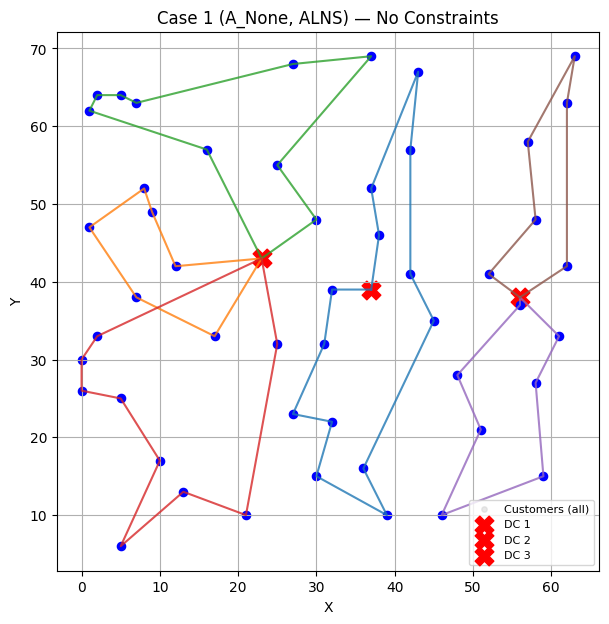

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48260 (\N{HANGUL SYLLABLE BEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


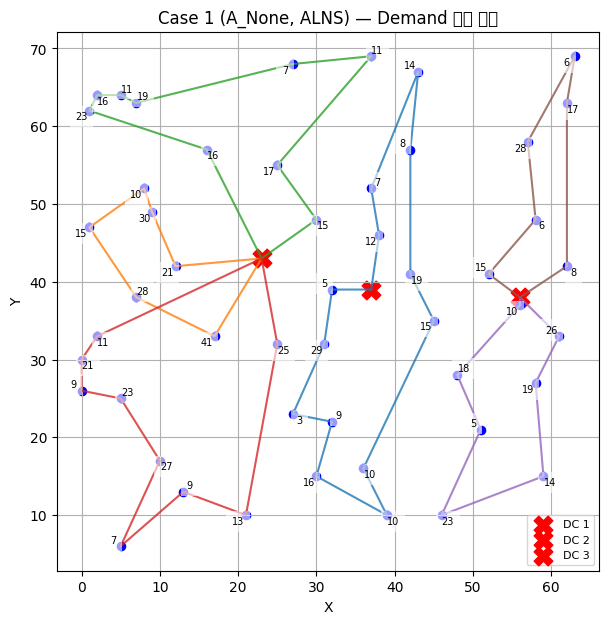

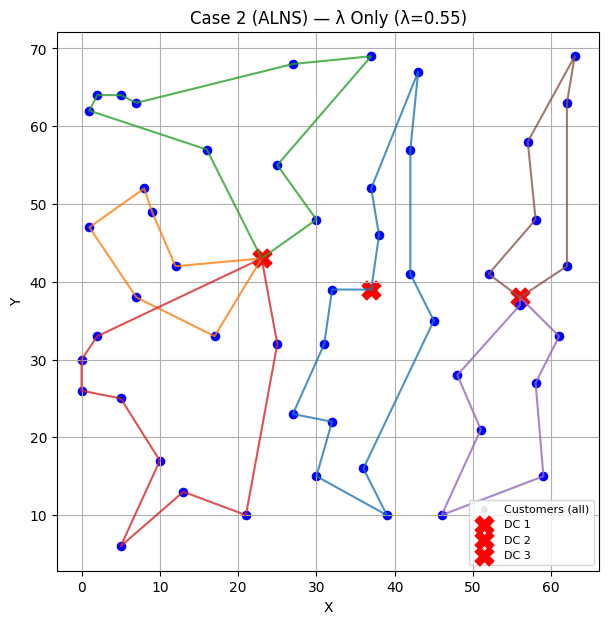

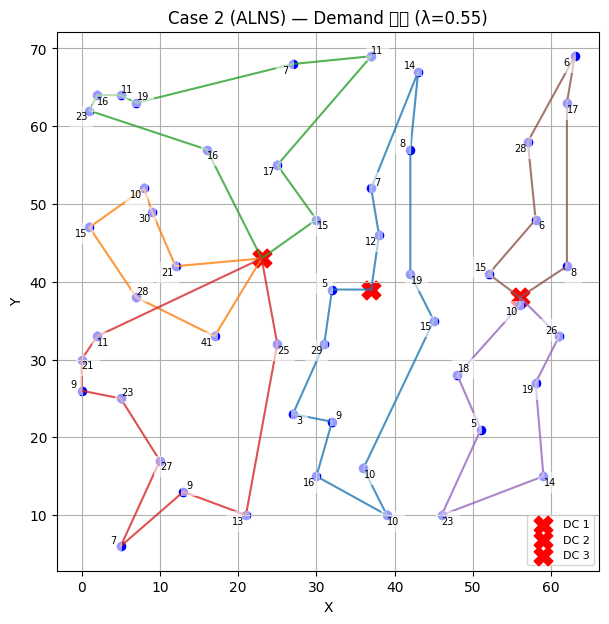

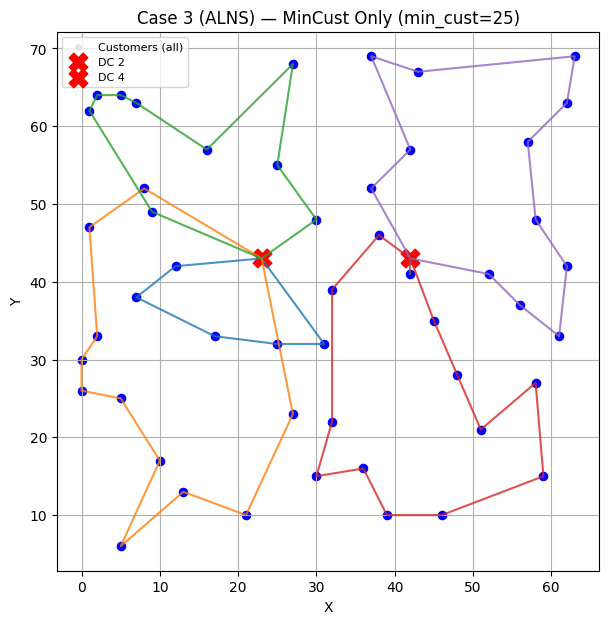

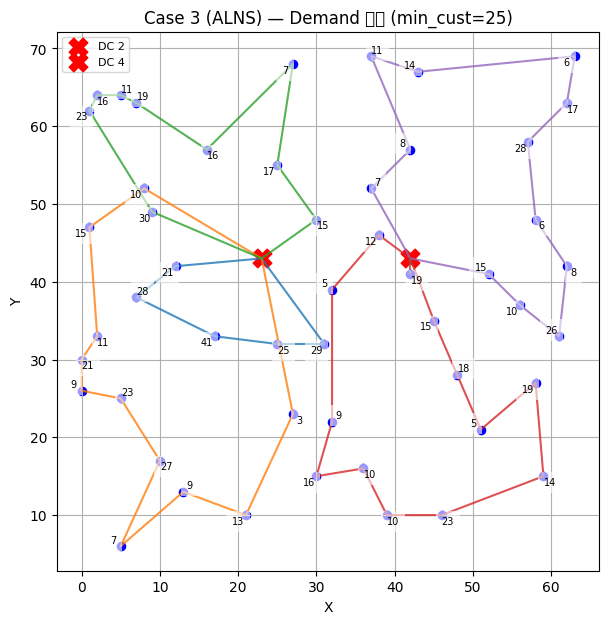

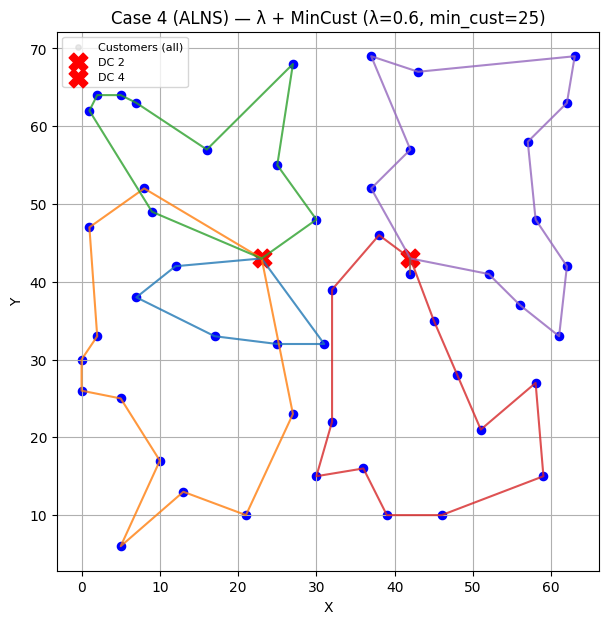

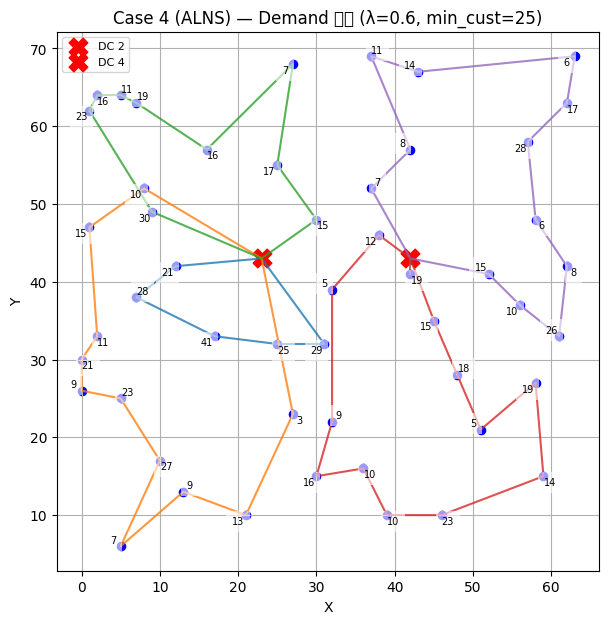

In [6]:
# ================================================================
# 공통 시각화 함수 (CPLEX + ALNS 버전)
#  - plot_case_all_dc           : 경로만 표시
#  - plot_case_all_dc_with_demand : 경로 + 수요(DEMAND) 라벨 한 번씩만 표시
# ================================================================
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1) DC별 경로 전체를 한 그림에 그려주는 버전
# ------------------------------------------------
def plot_case_all_dc(result, title=""):
    """
    result: solve_milp_and_vrp_alns(...)가 반환한 dict
    title : 플롯 제목
    """
    if result is None:
        print(f"[{title}] 결과가 없습니다 (infeasible or failed).")
        return

    routes_detail = result["routes_detail"]
    opened        = result["opened"]

    plt.figure(figsize=(7, 7))

    # 전체 고객 위치를 옅게 찍기 (배경용)
    plt.scatter(customer["X"], customer["Y"],
                c="lightgray", s=15, alpha=0.5, label="Customers (all)")

    for dc_id in opened:
        detail = routes_detail[dc_id]
        routes = detail["routes"]
        locs   = detail["locs"]   # depot + 고객 위치들

        # DC 표시
        x_dc, y_dc = locs[0]
        plt.scatter(x_dc, y_dc, c="red", marker="X", s=180, label=f"DC {dc_id}")

        # 경로 표시
        for r_idx, route in enumerate(routes):
            xs, ys = [], []
            for node in route:
                x, y = locs[node]
                xs.append(x); ys.append(y)

                # 고객 노드면 파란 점으로
                if node != 0:
                    plt.scatter(x, y, c="blue", s=35)
            # 경로 선
            plt.plot(xs, ys, alpha=0.8)

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)

    # 중복 레이블 제거 (DC 여러 개 있을 때)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize=8)

    plt.show()


# ================================================================
# 2) Demand(수요) 라벨을 고객 옆에 "한 번만" 표시하는 시각화 버전
# ================================================================
def plot_case_all_dc_with_demand(result, title=""):
    if result is None:
        print(f"[{title}] 결과가 없습니다 (infeasible or failed).")
        return

    routes_detail = result["routes_detail"]
    opened        = result["opened"]

    plt.figure(figsize=(7, 7))

    # 전체 고객 위치만 옅게 찍기 (텍스트 X)
    plt.scatter(customer["X"], customer["Y"],
                c="lightgray", s=15, alpha=0.5)

    # 이미 라벨 찍은 고객은 다시 안 찍도록 관리
    already_labeled = set()

    for dc_id in opened:
        detail = routes_detail[dc_id]
        routes = detail["routes"]
        locs   = detail["locs"]   # depot + 고객 위치들

        # DC
        x_dc, y_dc = locs[0]
        plt.scatter(x_dc, y_dc, c="red", marker="X", s=180, label=f"DC {dc_id}")

        # 경로 표시
        for r_idx, route in enumerate(routes):
            xs, ys = [], []
            for node in route:
                x, y = locs[node]
                xs.append(x); ys.append(y)

                if node != 0:
                    plt.scatter(x, y, c="blue", s=35)

                    # global customer index
                    # locs: [DC, customer0, customer1, ...]
                    # node==1 → customers[0]
                    global_index = detail["customers"][node-1]

                    # 아직 라벨 안 찍은 고객만 표시
                    if global_index not in already_labeled:
                        d = int(customer.loc[global_index, "DEMAND"])

                        # index에 따라 살짝 다른 방향으로 밀어주기 (겹침 완화)
                        dx = 0.8 if (global_index % 2 == 0) else -1.0
                        dy = 0.8 if (global_index % 3 == 0) else -0.8

                        plt.text(
                            x + dx, y + dy, f"{d}",
                            fontsize=7, color="black",
                            ha="center", va="center",
                            bbox=dict(facecolor="white",
                                      edgecolor="none",
                                      alpha=0.6)
                        )
                        already_labeled.add(global_index)

            plt.plot(xs, ys, alpha=0.8)

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)

    # 중복 레이블 제거
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize=8)

    plt.show()


# ============================
# Case별 2장씩 시각화 호출
# ============================

# ---- Case 1 ----
plot_case_all_dc(
    results_all["A_None"],
    title="Case 1 (A_None, ALNS) — No Constraints"
)

plot_case_all_dc_with_demand(
    results_all["A_None"],
    title="Case 1 (A_None, ALNS) — Demand 표시 버전"
)

# ---- Case 2 ----
plot_case_all_dc(
    results_all["B_LambdaOnly"],
    title=f"Case 2 (ALNS) — λ Only (λ={results_all['B_LambdaOnly']['lambda']})"
)

plot_case_all_dc_with_demand(
    results_all["B_LambdaOnly"],
    title=f"Case 2 (ALNS) — Demand 표시 (λ={results_all['B_LambdaOnly']['lambda']})"
)

# ---- Case 3 ----
plot_case_all_dc(
    results_all["C_MinCustOnly"],
    title=f"Case 3 (ALNS) — MinCust Only (min_cust={results_all['C_MinCustOnly']['min_cust']})"
)

plot_case_all_dc_with_demand(
    results_all["C_MinCustOnly"],
    title=f"Case 3 (ALNS) — Demand 표시 (min_cust={results_all['C_MinCustOnly']['min_cust']})"
)

# ---- Case 4 ----
plot_case_all_dc(
    results_all["D_Both"],
    title=f"Case 4 (ALNS) — λ + MinCust (λ={results_all['D_Both']['lambda']}, min_cust={results_all['D_Both']['min_cust']})"
)

plot_case_all_dc_with_demand(
    results_all["D_Both"],
    title=f"Case 4 (ALNS) — Demand 표시 (λ={results_all['D_Both']['lambda']}, min_cust={results_all['D_Both']['min_cust']})"
)
